<a href="https://colab.research.google.com/github/SamCor80/Codigos-Pregrado_Fisica/blob/main/Varios/Trabajo%20de%20Grado%20-%20Gr%C3%A1ficas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Varian_TrueBeam6MV_01"

PDD

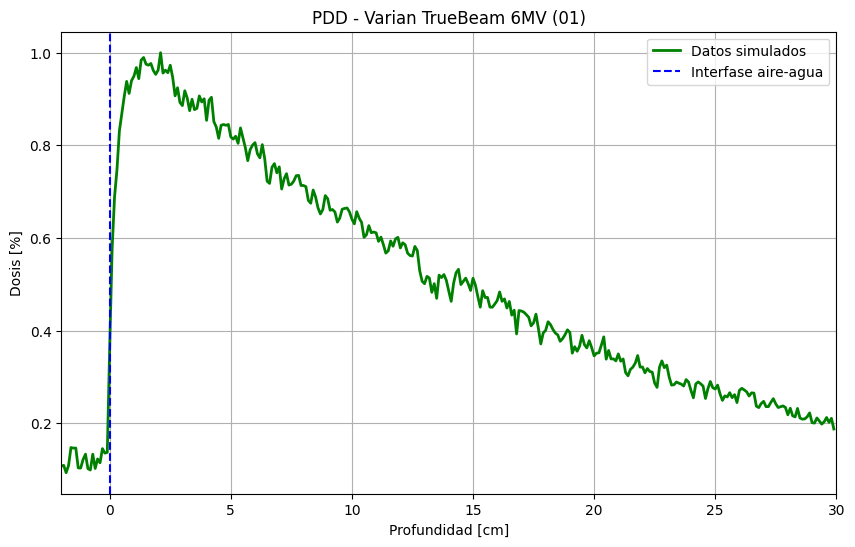

1.110316134145251e-06
     X  Y    Z          Dose
0    0  0    0  1.194137e-07
1    0  0    1  1.213242e-07
2    0  0    2  1.036179e-07
3    0  0    3  1.207553e-07
4    0  0    4  1.639895e-07
..  .. ..  ...           ...
315  0  0  315  2.257159e-07
316  0  0  316  2.359552e-07
317  0  0  317  2.243220e-07
318  0  0  318  2.339912e-07
319  0  0  319  2.084226e-07

[320 rows x 4 columns]
       Z          Dose  Dose_normalized
0      0  1.194137e-07         0.107549
1      1  1.213242e-07         0.109270
2      2  1.036179e-07         0.093323
3      3  1.207553e-07         0.108758
4      4  1.639895e-07         0.147696
..   ...           ...              ...
315  315  2.257159e-07         0.203290
316  316  2.359552e-07         0.212512
317  317  2.243220e-07         0.202034
318  318  2.339912e-07         0.210743
319  319  2.084226e-07         0.187715

[320 rows x 3 columns]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pdd_file_medio_1 = "DosisAProfundidad_01.csv"
dataf_medio_1 = pd.read_csv(pdd_file_medio_1, skiprows = 8, header=None)
dataf_medio_1.columns = ["X", "Y", "Z", "Dose"]
pdd_data_medio_1 = dataf_medio_1.groupby("Z")["Dose"].mean().reset_index()

dose_max = pdd_data_medio_1['Dose'].max()
pdd_data_medio_1['Dose_normalized'] = pdd_data_medio_1['Dose'] / dose_max

Z = np.arange(-2, 30, 0.1)
plt.figure(figsize=(10, 6))
plt.plot(Z, pdd_data_medio_1['Dose_normalized'], linewidth = 2.0, color = "g", label = "Datos simulados")
plt.xlabel('Profundidad [cm]')
plt.ylabel('Dosis [%]')
plt.xlim(-2, 30)
plt.axvline(x = 0, color = 'b', linestyle = '--', label = 'Interfase aire-agua')
plt.title('PDD - Varian TrueBeam 6MV (01)')
plt.grid(True)
plt.legend()
plt.show()

print(dose_max)

print(dataf_medio_1)
print(pdd_data_medio_1)

PDD cerca a la interfase

ValueError: x and y must have same first dimension, but have shapes (301,) and (320,)

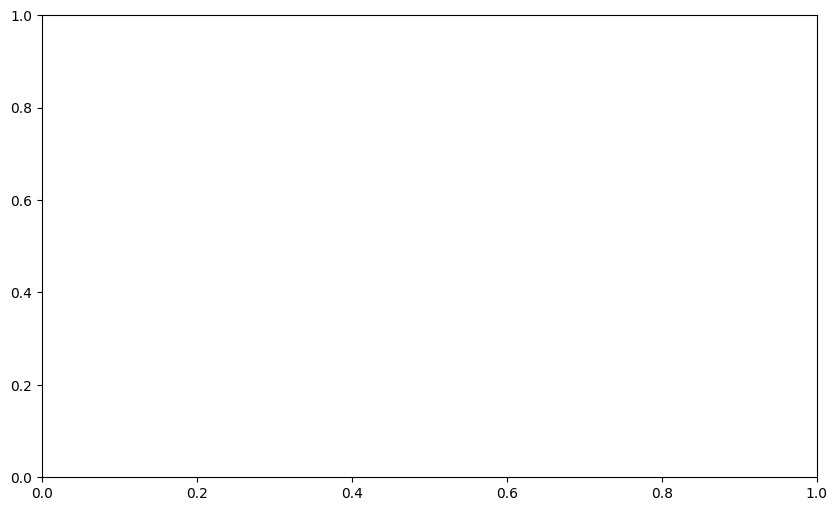

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(Z, pdd_data_medio_1['Dose_normalized'], "sg", label = "Datos simulados")
plt.xlabel('Profundidad [cm]')
plt.ylabel('Dosis [%]')
plt.xlim(-1, 1)
plt.axvline(x = 0, color = 'b', linestyle = '--', label = 'Interfase aire-agua')
plt.title('PDD cerca a la interfase - Varian TrueBeam 6MV (01)')
plt.grid(True)
plt.legend()
plt.show()

Mapa superficial de dosis:

Picos detectados: 489 (4.890%)


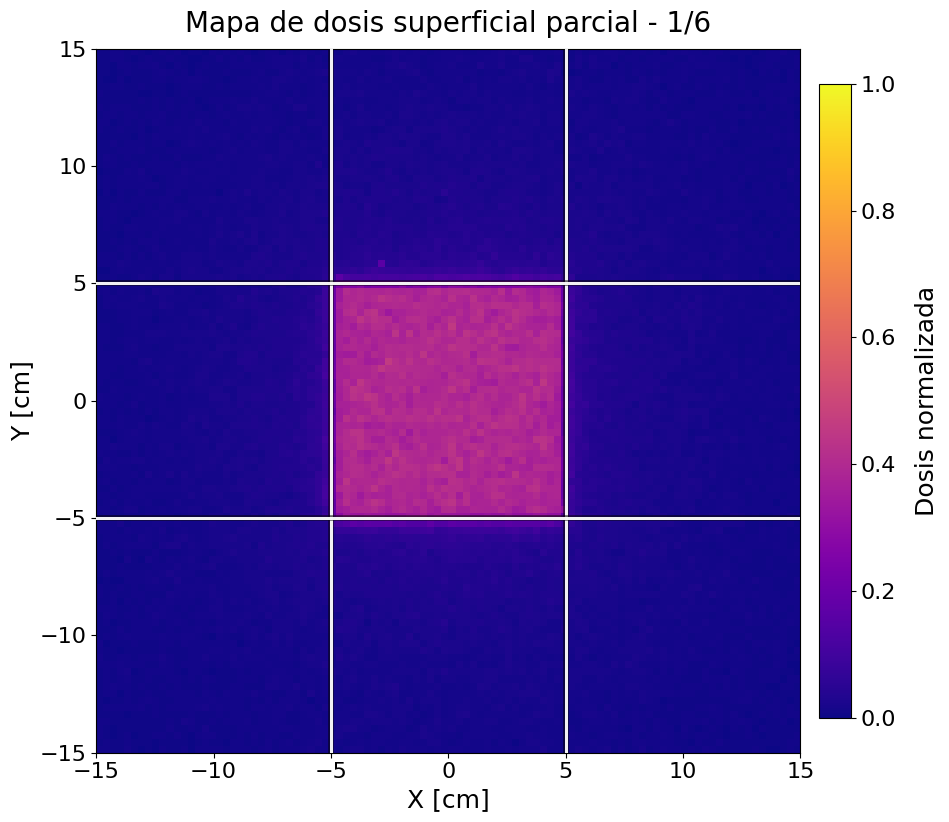

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as pe
from scipy.ndimage import median_filter, gaussian_filter

plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 20,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
})

def read_surfmap_csv(path, skiprows=8):
    """
    Lee un CSV de TOPAS (o similar) con 4 columnas: X,Y,Z,Dose y header textual.
    Ajusta skiprows si tu archivo tiene más/menos líneas de header.
    """
    df = pd.read_csv(path, skiprows=skiprows, header=None)
    df.columns = ["X", "Y", "Z", "Dose"]
    return df

def build_dose_matrix_single(df, x_col="X", y_col="Y", dose_col="Dose", normalize_mode="max"):
    """
    Construye una matriz 2D (Y vs X) con dosis normalizada en [0,1].
    normalize_mode:
      - "max": normaliza por el máximo global de Dose
      - "p99": normaliza por el percentil 99 (robusto si hay picos extremos)
    """
    df = df.copy()

    if normalize_mode == "p99":
        norm = np.nanpercentile(df[dose_col].to_numpy(dtype=float), 99)
        norm = norm if norm > 0 else df[dose_col].max()
    else:
        norm = df[dose_col].max()

    df["Dose_normalized"] = df[dose_col].to_numpy(dtype=float) / norm
    df["Dose_normalized"] = np.clip(df["Dose_normalized"], 0.0, 1.0)

    pivot = df.pivot(index=y_col, columns=x_col, values="Dose_normalized")
    pivot = pivot.sort_index(axis=0).sort_index(axis=1)

    matriz = pivot.to_numpy()
    x_unique = pivot.columns.to_numpy()
    y_unique = pivot.index.to_numpy()

    return df, matriz, x_unique, y_unique

def despike_matrix(matriz, window=4, z_thresh=6.0, mode="reflect"):
    """
    Detecta picos aislados con criterio robusto (mediana local + MAD local) y los reemplaza
    por la mediana local.
    """
    matriz = np.asarray(matriz, dtype=float)

    med = median_filter(matriz, size=window, mode=mode)
    resid = matriz - med
    mad = median_filter(np.abs(resid), size=window, mode=mode)

    eps = 1e-12
    robust_sigma = 1.4826 * mad + eps
    z = np.abs(resid) / robust_sigma

    spike_mask = z > z_thresh

    matriz_corr = matriz.copy()
    matriz_corr[spike_mask] = med[spike_mask]

    stats = {
        "n_spikes": int(spike_mask.sum()),
        "frac_spikes": float(spike_mask.mean()),
        "window": window,
        "z_thresh": z_thresh
    }
    return matriz_corr, spike_mask, stats

def plot_heatmap(matriz, title="", n_ticks=7, xlim=(-15, 15), ylim=(-15, 15),
                 save=True, out_png="MapaDosisSuperficial.png", dpi=600):
    """
    Heatmap con ejes físicos -15..15 (cm), colorbar [0,1] y líneas guía en ±5 cm.
    """
    matriz = np.asarray(matriz, dtype=float)
    matriz = np.clip(matriz, 0.0, 1.0)

    fig, ax = plt.subplots(figsize=(10.5, 8.5))

    im = ax.imshow(
        matriz,
        origin="lower",
        extent=[xlim[0], xlim[1], ylim[0], ylim[1]],
        cmap="plasma",
        vmin=0.0,
        vmax=1.0,
        aspect="equal",
        interpolation="nearest"
    )

    ax.set_title(title, pad=12)
    ax.set_xlabel("X [cm]")
    ax.set_ylabel("Y [cm]")

    ax.set_xticks(np.linspace(xlim[0], xlim[1], n_ticks))
    ax.set_yticks(np.linspace(ylim[0], ylim[1], n_ticks))

    cbar = fig.colorbar(im, ax=ax, shrink=0.9, pad=0.02)
    cbar.set_label("Dosis normalizada", rotation=90, labelpad=14)
    cbar.set_ticks(np.linspace(0, 1, 6))
    guide_style = dict(color="white", linewidth=2.2, alpha=0.95, linestyle="-", zorder=3)
    stroke = [pe.Stroke(linewidth=4.0, foreground="black", alpha=0.6), pe.Normal()]

    for x in (-5, 5):
        ln = ax.axvline(x=x, **guide_style)
        ln.set_path_effects(stroke)

    for y in (-5, 5):
        ln = ax.axhline(y=y, **guide_style)
        ln.set_path_effects(stroke)

    plt.tight_layout()

    if save:
        plt.savefig(out_png, dpi=dpi, bbox_inches="tight", facecolor="white")

    plt.show()

surfmap_file = "MapaSuperficial_01.csv"
df_raw = read_surfmap_csv(surfmap_file, skiprows=8)
surfmap_data_by_z = df_raw.groupby("Z")["Dose"].mean().reset_index()
df_norm, matriz, x_unique, y_unique = build_dose_matrix_single(
    df_raw,
    x_col="X",
    y_col="Y",
    dose_col="Dose",
    normalize_mode="max"
)
matriz_despiked, mask_spikes, stats = despike_matrix(matriz, window=2, z_thresh=2.5)
print(f"Picos detectados: {stats['n_spikes']} ({100*stats['frac_spikes']:.3f}%)")
matriz_corr = gaussian_filter(matriz_despiked, sigma=0.1, mode="reflect")
matriz_corr = np.clip(matriz_corr, 0.0, 1.0)
plot_heatmap(
    matriz_corr,
    title="Mapa de dosis superficial parcial - 1/6",
    n_ticks=7,
    xlim=(-15, 15),
    ylim=(-15, 15),
    save=True,
    out_png="MapaDosisSuperficial_01.png",
    dpi=600
)


Perfiles transversales

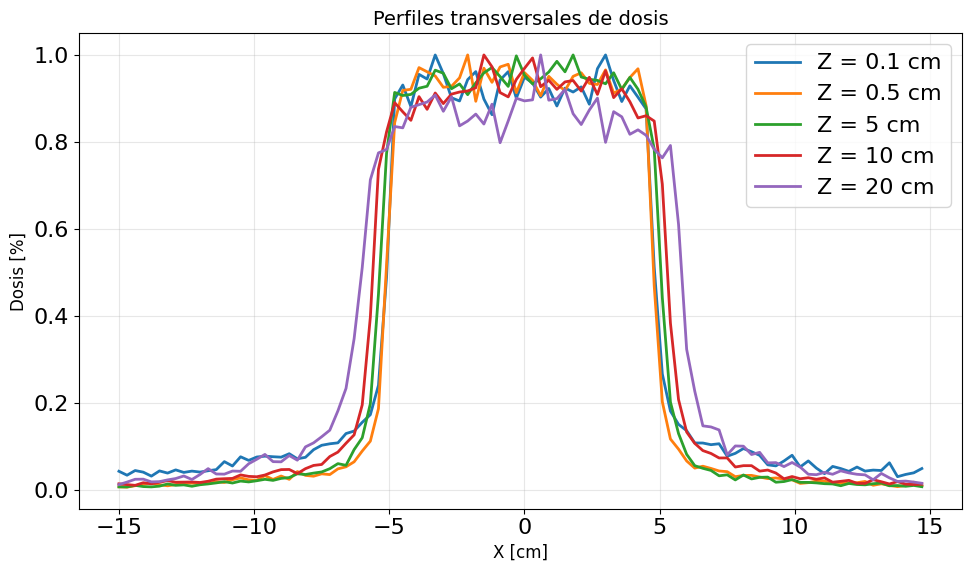

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 0.1 cm

perfil01_file_medio_1 = "Perfil01cm_01.csv"
datapf01_medio_1 = pd.read_csv(perfil01_file_medio_1, skiprows=8, header=None)
datapf01_medio_1.columns = ["X", "Y", "Z", "Dose"]
perfil01_data_medio_1 = datapf01_medio_1.groupby("X")["Dose"].mean().reset_index()
dose_max = perfil01_data_medio_1['Dose'].max()
perfil01_data_medio_1['Dose_normalized'] = perfil01_data_medio_1['Dose'] / dose_max

# 0.5 cm

perfil05_file_medio_1 = "Perfil05cm_01.csv"
datapf05_medio_1 = pd.read_csv(perfil05_file_medio_1, skiprows=8, header=None)
datapf05_medio_1.columns = ["X", "Y", "Z", "Dose"]
perfil05_data_medio_1 = datapf05_medio_1.groupby("X")["Dose"].mean().reset_index()
dose_max = perfil05_data_medio_1['Dose'].max()
perfil05_data_medio_1['Dose_normalized'] = perfil05_data_medio_1['Dose'] / dose_max

# 5 cm

perfil5_file_medio_1 = "Perfil5cm_01.csv"
datapf5_medio_1 = pd.read_csv(perfil5_file_medio_1, skiprows=8, header=None)
datapf5_medio_1.columns = ["X", "Y", "Z", "Dose"]
perfil5_data_medio_1 = datapf5_medio_1.groupby("X")["Dose"].mean().reset_index()
dose_max = perfil5_data_medio_1['Dose'].max()
perfil5_data_medio_1['Dose_normalized'] = perfil5_data_medio_1['Dose'] / dose_max

# 10 cm

perfil10_file_medio_1 = "Perfil10cm_01.csv"
datapf10_medio_1 = pd.read_csv(perfil10_file_medio_1, skiprows=8, header=None)
datapf10_medio_1.columns = ["X", "Y", "Z", "Dose"]
perfil10_data_medio_1 = datapf10_medio_1.groupby("X")["Dose"].mean().reset_index()
dose_max = perfil10_data_medio_1['Dose'].max()
perfil10_data_medio_1['Dose_normalized'] = perfil10_data_medio_1['Dose'] / dose_max

# 20 cm

perfil20_file_medio_1 = "Perfil20cm_01.csv"
datapf20_medio_1 = pd.read_csv(perfil20_file_medio_1, skiprows=8, header=None)
datapf20_medio_1.columns = ["X", "Y", "Z", "Dose"]
perfil20_data_medio_1 = datapf20_medio_1.groupby("X")["Dose"].mean().reset_index()
dose_max = perfil20_data_medio_1['Dose'].max()
perfil20_data_medio_1['Dose_normalized'] = perfil20_data_medio_1['Dose'] / dose_max


X = np.arange(-15, 15, 0.3)
plt.figure(figsize=(10, 6))
plt.plot(X, perfil01_data_medio_1['Dose_normalized'], label = "Z = 0.1 cm", linewidth=2)
plt.plot(X, perfil05_data_medio_1['Dose_normalized'], label = "Z = 0.5 cm", linewidth=2)
plt.plot(X, perfil5_data_medio_1['Dose_normalized'], label = "Z = 5 cm", linewidth=2)
plt.plot(X, perfil10_data_medio_1['Dose_normalized'], label = "Z = 10 cm", linewidth=2)
plt.plot(X, perfil20_data_medio_1['Dose_normalized'], label = "Z = 20 cm", linewidth=2)
plt.xlabel('X [cm]', fontsize=12)
plt.ylabel('Dosis [%]', fontsize=12)
plt.title('Perfiles transversales de dosis', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# "Varian_TrueBeam6MV_02"

PDD:

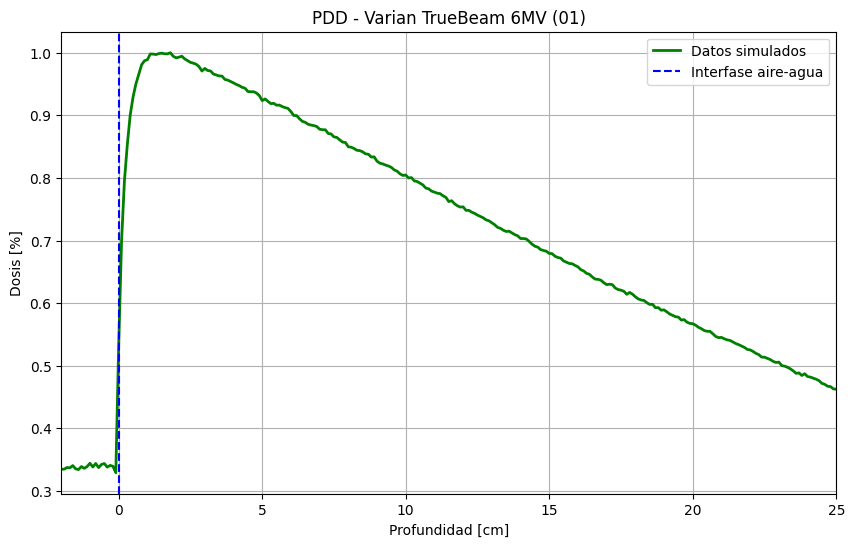

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pdd_file_medio_2 = "DosisAProfundidad_02.csv"
dataf_medio_2 = pd.read_csv(pdd_file_medio_2, skiprows = 8, header=None)
dataf_medio_2.columns = ["X", "Y", "Z", "Dose"]
pdd_data_medio_2 = dataf_medio_2.groupby("Z")["Dose"].mean().reset_index()

dose_max = pdd_data_medio_2['Dose'].max()
pdd_data_medio_2['Dose_normalized'] = pdd_data_medio_2['Dose'] / dose_max

Z = np.arange(-2, 30, 0.1)
plt.figure(figsize=(10, 6))
plt.plot(Z, pdd_data_medio_2['Dose_normalized'], linewidth = 2.0, color = "g", label = "Datos simulados")
plt.xlabel('Profundidad [cm]')
plt.ylabel('Dosis [%]')
plt.xlim(-2, 25)
plt.axvline(x = 0, color = 'b', linestyle = '--', label = 'Interfase aire-agua')
plt.title('PDD - Varian TrueBeam 6MV (02)')
plt.grid(True)
plt.legend()
plt.show()

PDD cerca a la interfase:

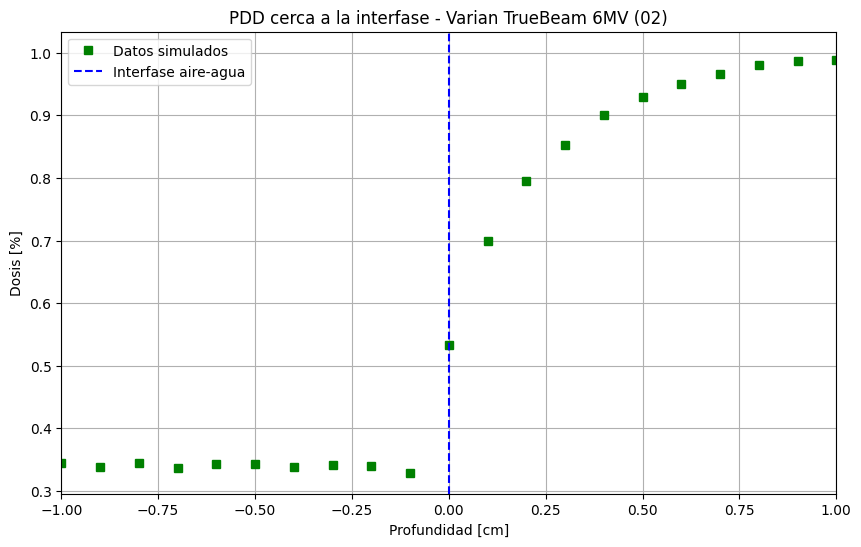

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(Z, pdd_data_medio_2['Dose_normalized'], "sg", label = "Datos simulados")
plt.xlabel('Profundidad [cm]')
plt.ylabel('Dosis [%]')
plt.xlim(-1, 1)
plt.axvline(x = 0, color = 'b', linestyle = '--', label = 'Interfase aire-agua')
plt.title('PDD cerca a la interfase - Varian TrueBeam 6MV (02)')
plt.grid(True)
plt.legend()
plt.show()

Mapa superficial de dosis:

Picos detectados: 494 (4.940%)


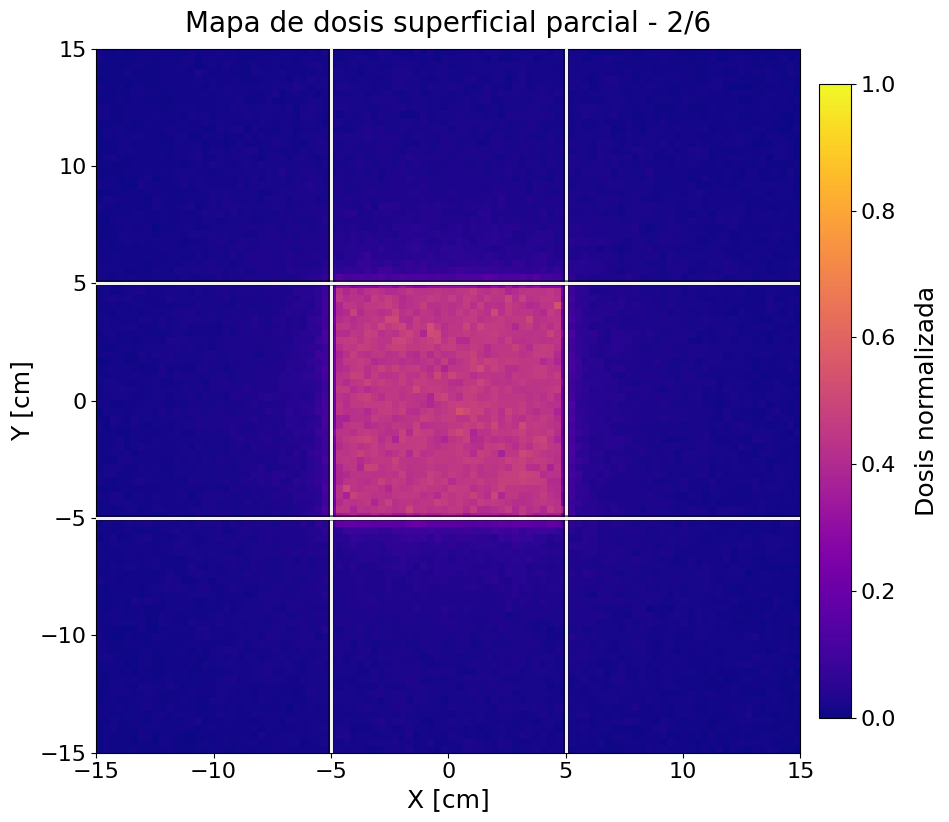

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as pe
from scipy.ndimage import median_filter, gaussian_filter

plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 20,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
})

def read_surfmap_csv(path, skiprows=8):
    """
    Lee un CSV de TOPAS (o similar) con 4 columnas: X,Y,Z,Dose y header textual.
    Ajusta skiprows si tu archivo tiene más/menos líneas de header.
    """
    df = pd.read_csv(path, skiprows=skiprows, header=None)
    df.columns = ["X", "Y", "Z", "Dose"]
    return df

def build_dose_matrix_single(df, x_col="X", y_col="Y", dose_col="Dose", normalize_mode="max"):
    """
    Construye una matriz 2D (Y vs X) con dosis normalizada en [0,1].
    normalize_mode:
      - "max": normaliza por el máximo global de Dose
      - "p99": normaliza por el percentil 99 (robusto si hay picos extremos)
    """
    df = df.copy()

    if normalize_mode == "p99":
        norm = np.nanpercentile(df[dose_col].to_numpy(dtype=float), 99)
        norm = norm if norm > 0 else df[dose_col].max()
    else:
        norm = df[dose_col].max()

    df["Dose_normalized"] = df[dose_col].to_numpy(dtype=float) / norm
    df["Dose_normalized"] = np.clip(df["Dose_normalized"], 0.0, 1.0)

    pivot = df.pivot(index=y_col, columns=x_col, values="Dose_normalized")
    pivot = pivot.sort_index(axis=0).sort_index(axis=1)

    matriz = pivot.to_numpy()
    x_unique = pivot.columns.to_numpy()
    y_unique = pivot.index.to_numpy()

    return df, matriz, x_unique, y_unique

def despike_matrix(matriz, window=4, z_thresh=6.0, mode="reflect"):
    """
    Detecta picos aislados con criterio robusto (mediana local + MAD local) y los reemplaza
    por la mediana local.
    """
    matriz = np.asarray(matriz, dtype=float)

    med = median_filter(matriz, size=window, mode=mode)
    resid = matriz - med
    mad = median_filter(np.abs(resid), size=window, mode=mode)

    eps = 1e-12
    robust_sigma = 1.4826 * mad + eps
    z = np.abs(resid) / robust_sigma

    spike_mask = z > z_thresh

    matriz_corr = matriz.copy()
    matriz_corr[spike_mask] = med[spike_mask]

    stats = {
        "n_spikes": int(spike_mask.sum()),
        "frac_spikes": float(spike_mask.mean()),
        "window": window,
        "z_thresh": z_thresh
    }
    return matriz_corr, spike_mask, stats

def plot_heatmap(matriz, title="", n_ticks=7, xlim=(-15, 15), ylim=(-15, 15),
                 save=True, out_png="MapaDosisSuperficial.png", dpi=600):
    """
    Heatmap con ejes físicos -15..15 (cm), colorbar [0,1] y líneas guía en ±5 cm.
    """
    matriz = np.asarray(matriz, dtype=float)
    matriz = np.clip(matriz, 0.0, 1.0)

    fig, ax = plt.subplots(figsize=(10.5, 8.5))

    im = ax.imshow(
        matriz,
        origin="lower",
        extent=[xlim[0], xlim[1], ylim[0], ylim[1]],
        cmap="plasma",
        vmin=0.0,
        vmax=1.0,
        aspect="equal",
        interpolation="nearest"
    )

    ax.set_title(title, pad=12)
    ax.set_xlabel("X [cm]")
    ax.set_ylabel("Y [cm]")

    ax.set_xticks(np.linspace(xlim[0], xlim[1], n_ticks))
    ax.set_yticks(np.linspace(ylim[0], ylim[1], n_ticks))

    cbar = fig.colorbar(im, ax=ax, shrink=0.9, pad=0.02)
    cbar.set_label("Dosis normalizada", rotation=90, labelpad=14)
    cbar.set_ticks(np.linspace(0, 1, 6))
    guide_style = dict(color="white", linewidth=2.2, alpha=0.95, linestyle="-", zorder=3)
    stroke = [pe.Stroke(linewidth=4.0, foreground="black", alpha=0.6), pe.Normal()]

    for x in (-5, 5):
        ln = ax.axvline(x=x, **guide_style)
        ln.set_path_effects(stroke)

    for y in (-5, 5):
        ln = ax.axhline(y=y, **guide_style)
        ln.set_path_effects(stroke)

    plt.tight_layout()

    if save:
        plt.savefig(out_png, dpi=dpi, bbox_inches="tight", facecolor="white")

    plt.show()
surfmap_file = "MapaSuperficial_02.csv"
df_raw = read_surfmap_csv(surfmap_file, skiprows=8)
surfmap_data_by_z = df_raw.groupby("Z")["Dose"].mean().reset_index()
df_norm, matriz, x_unique, y_unique = build_dose_matrix_single(
    df_raw,
    x_col="X",
    y_col="Y",
    dose_col="Dose",
    normalize_mode="max"
)
matriz_despiked, mask_spikes, stats = despike_matrix(matriz, window=2, z_thresh=2.5)
print(f"Picos detectados: {stats['n_spikes']} ({100*stats['frac_spikes']:.3f}%)")

matriz_corr = gaussian_filter(matriz_despiked, sigma=0.1, mode="reflect")
matriz_corr = np.clip(matriz_corr, 0.0, 1.0)
plot_heatmap(
    matriz_corr,
    title="Mapa de dosis superficial parcial - 2/6",
    n_ticks=7,
    xlim=(-15, 15),
    ylim=(-15, 15),
    save=True,
    out_png="MapaDosisSuperficial_02.png",
    dpi=600
)


Perfiles transversales:

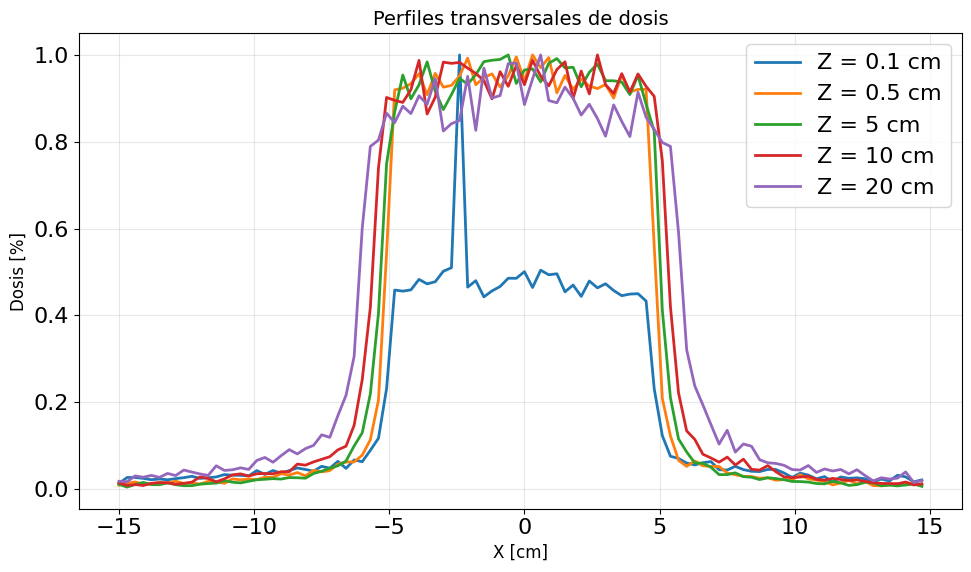

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 0.1 cm

perfil01_file_medio_2 = "Perfil01cm_02.csv"
datapf01_medio_2 = pd.read_csv(perfil01_file_medio_2, skiprows=8, header=None)
datapf01_medio_2.columns = ["X", "Y", "Z", "Dose"]
perfil01_data_medio_2 = datapf01_medio_2.groupby("X")["Dose"].mean().reset_index()
dose_max = perfil01_data_medio_2['Dose'].max()
perfil01_data_medio_2['Dose_normalized'] = perfil01_data_medio_2['Dose'] / dose_max

# 0.5 cm

perfil05_file_medio_2 = "Perfil05cm_02.csv"
datapf05_medio_2 = pd.read_csv(perfil05_file_medio_2, skiprows=8, header=None)
datapf05_medio_2.columns = ["X", "Y", "Z", "Dose"]
perfil05_data_medio_2 = datapf05_medio_2.groupby("X")["Dose"].mean().reset_index()
dose_max = perfil05_data_medio_2['Dose'].max()
perfil05_data_medio_2['Dose_normalized'] = perfil05_data_medio_2['Dose'] / dose_max

# 5 cm

perfil5_file_medio_2 = "Perfil5cm_02.csv"
datapf5_medio_2 = pd.read_csv(perfil5_file_medio_2, skiprows=8, header=None)
datapf5_medio_2.columns = ["X", "Y", "Z", "Dose"]
perfil5_data_medio_2 = datapf5_medio_2.groupby("X")["Dose"].mean().reset_index()
dose_max = perfil5_data_medio_2['Dose'].max()
perfil5_data_medio_2['Dose_normalized'] = perfil5_data_medio_2['Dose'] / dose_max

# 10 cm

perfil10_file_medio_2 = "Perfil10cm_02.csv"
datapf10_medio_2 = pd.read_csv(perfil10_file_medio_2, skiprows=8, header=None)
datapf10_medio_2.columns = ["X", "Y", "Z", "Dose"]
perfil10_data_medio_2 = datapf10_medio_2.groupby("X")["Dose"].mean().reset_index()
dose_max = perfil10_data_medio_2['Dose'].max()
perfil10_data_medio_2['Dose_normalized'] = perfil10_data_medio_2['Dose'] / dose_max

# 20 cm

perfil20_file_medio_2 = "Perfil20cm_02.csv"
datapf20_medio_2 = pd.read_csv(perfil20_file_medio_2, skiprows=8, header=None)
datapf20_medio_2.columns = ["X", "Y", "Z", "Dose"]
perfil20_data_medio_2 = datapf20_medio_2.groupby("X")["Dose"].mean().reset_index()
dose_max = perfil20_data_medio_2['Dose'].max()
perfil20_data_medio_2['Dose_normalized'] = perfil20_data_medio_2['Dose'] / dose_max


X = np.arange(-15, 15, 0.3)
plt.figure(figsize=(10, 6))
plt.plot(X, perfil01_data_medio_2['Dose_normalized'], label = "Z = 0.1 cm", linewidth=2)
plt.plot(X, perfil05_data_medio_2['Dose_normalized'], label = "Z = 0.5 cm", linewidth=2)
plt.plot(X, perfil5_data_medio_2['Dose_normalized'], label = "Z = 5 cm", linewidth=2)
plt.plot(X, perfil10_data_medio_2['Dose_normalized'], label = "Z = 10 cm", linewidth=2)
plt.plot(X, perfil20_data_medio_2['Dose_normalized'], label = "Z = 20 cm", linewidth=2)
plt.xlabel('X [cm]', fontsize=12)
plt.ylabel('Dosis [%]', fontsize=12)
plt.title('Perfiles transversales de dosis', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# "Varian_TrueBeam6MV_03"



PDD:

1.40576233320644e-07


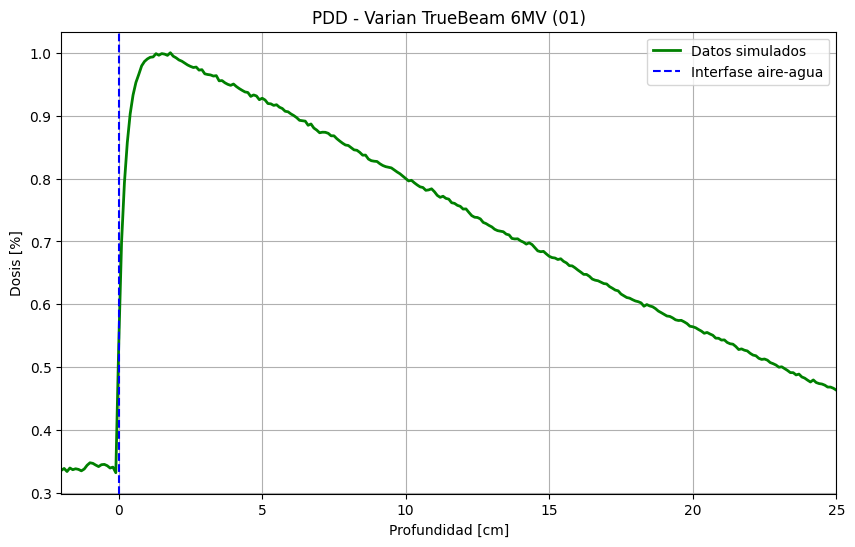

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pdd_file_medio_3 = "DosisAProfundidad_03.csv"
dataf_medio_3 = pd.read_csv(pdd_file_medio_3, skiprows = 8, header=None)
dataf_medio_3.columns = ["X", "Y", "Z", "Dose"]
pdd_data_medio_3 = dataf_medio_3.groupby("Z")["Dose"].mean().reset_index()

dose_max = pdd_data_medio_3['Dose'].max()

print(dose_max)

pdd_data_medio_3['Dose_normalized'] = pdd_data_medio_3['Dose'] / dose_max

Z = np.arange(-2, 30, 0.1)
plt.figure(figsize=(10, 6))
plt.plot(Z, pdd_data_medio_3['Dose_normalized'], linewidth = 2.0, color = "g", label = "Datos simulados")
plt.xlabel('Profundidad [cm]')
plt.ylabel('Dosis [%]')
plt.xlim(-2, 25)
plt.axvline(x = 0, color = 'b', linestyle = '--', label = 'Interfase aire-agua')
plt.title('PDD - Varian TrueBeam 6MV (01)')
plt.grid(True)
plt.legend()
plt.show()

PDD cerca a la interfase:

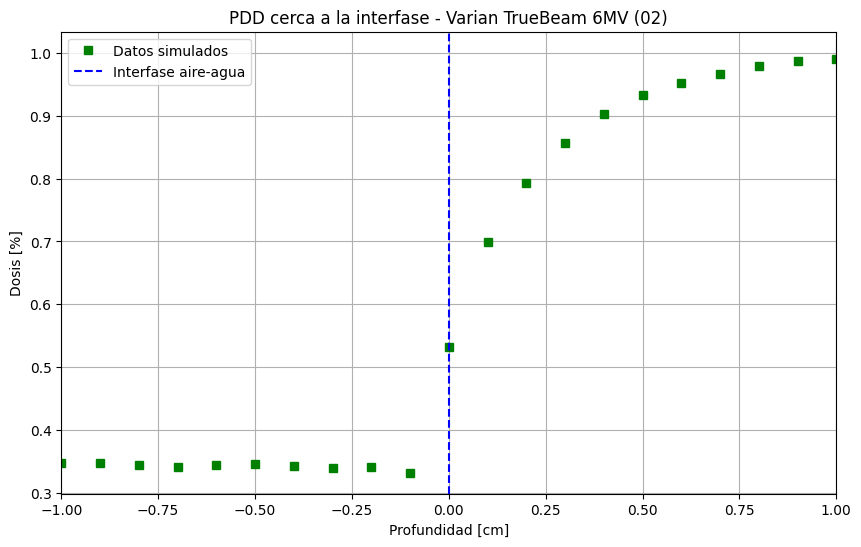

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(Z, pdd_data_medio_3['Dose_normalized'], "sg", label = "Datos simulados")
plt.xlabel('Profundidad [cm]')
plt.ylabel('Dosis [%]')
plt.xlim(-1, 1)
plt.axvline(x = 0, color = 'b', linestyle = '--', label = 'Interfase aire-agua')
plt.title('PDD cerca a la interfase - Varian TrueBeam 6MV (02)')
plt.grid(True)
plt.legend()
plt.show()

Mapa superficial de dosis:

Picos detectados: 491 (4.910%)


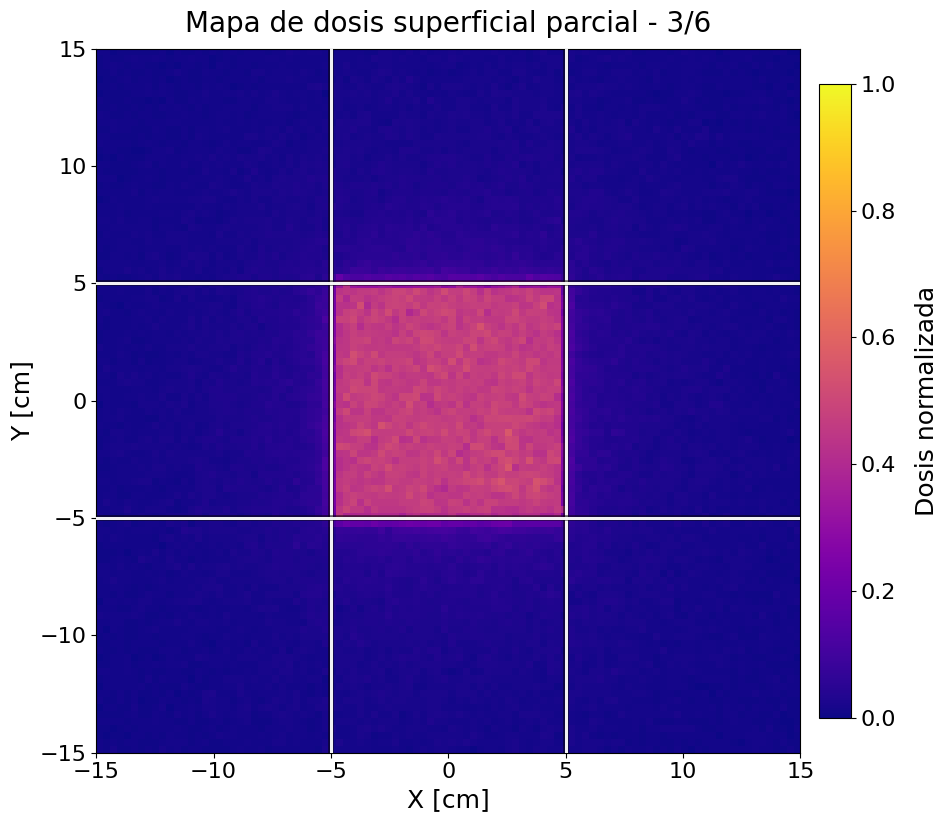

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as pe
from scipy.ndimage import median_filter, gaussian_filter

plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 20,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
})

def read_surfmap_csv(path, skiprows=8):
    """
    Lee un CSV de TOPAS (o similar) con 4 columnas: X,Y,Z,Dose y header textual.
    Ajusta skiprows si tu archivo tiene más/menos líneas de header.
    """
    df = pd.read_csv(path, skiprows=skiprows, header=None)
    df.columns = ["X", "Y", "Z", "Dose"]
    return df

def build_dose_matrix_single(df, x_col="X", y_col="Y", dose_col="Dose", normalize_mode="max"):
    """
    Construye una matriz 2D (Y vs X) con dosis normalizada en [0,1].
    normalize_mode:
      - "max": normaliza por el máximo global de Dose
      - "p99": normaliza por el percentil 99 (robusto si hay picos extremos)
    """
    df = df.copy()

    if normalize_mode == "p99":
        norm = np.nanpercentile(df[dose_col].to_numpy(dtype=float), 99)
        norm = norm if norm > 0 else df[dose_col].max()
    else:
        norm = df[dose_col].max()

    df["Dose_normalized"] = df[dose_col].to_numpy(dtype=float) / norm
    df["Dose_normalized"] = np.clip(df["Dose_normalized"], 0.0, 1.0)

    pivot = df.pivot(index=y_col, columns=x_col, values="Dose_normalized")
    pivot = pivot.sort_index(axis=0).sort_index(axis=1)

    matriz = pivot.to_numpy()
    x_unique = pivot.columns.to_numpy()
    y_unique = pivot.index.to_numpy()

    return df, matriz, x_unique, y_unique

def despike_matrix(matriz, window=4, z_thresh=6.0, mode="reflect"):
    """
    Detecta picos aislados con criterio robusto (mediana local + MAD local) y los reemplaza
    por la mediana local.
    """
    matriz = np.asarray(matriz, dtype=float)

    med = median_filter(matriz, size=window, mode=mode)
    resid = matriz - med
    mad = median_filter(np.abs(resid), size=window, mode=mode)

    eps = 1e-12
    robust_sigma = 1.4826 * mad + eps
    z = np.abs(resid) / robust_sigma

    spike_mask = z > z_thresh

    matriz_corr = matriz.copy()
    matriz_corr[spike_mask] = med[spike_mask]

    stats = {
        "n_spikes": int(spike_mask.sum()),
        "frac_spikes": float(spike_mask.mean()),
        "window": window,
        "z_thresh": z_thresh
    }
    return matriz_corr, spike_mask, stats

def plot_heatmap(matriz, title="", n_ticks=7, xlim=(-15, 15), ylim=(-15, 15),
                 save=True, out_png="MapaDosisSuperficial.png", dpi=600):
    """
    Heatmap con ejes físicos -15..15 (cm), colorbar [0,1] y líneas guía en ±5 cm.
    """
    matriz = np.asarray(matriz, dtype=float)
    matriz = np.clip(matriz, 0.0, 1.0)

    fig, ax = plt.subplots(figsize=(10.5, 8.5))

    im = ax.imshow(
        matriz,
        origin="lower",
        extent=[xlim[0], xlim[1], ylim[0], ylim[1]],
        cmap="plasma",
        vmin=0.0,
        vmax=1.0,
        aspect="equal",
        interpolation="nearest"
    )

    ax.set_title(title, pad=12)
    ax.set_xlabel("X [cm]")
    ax.set_ylabel("Y [cm]")

    ax.set_xticks(np.linspace(xlim[0], xlim[1], n_ticks))
    ax.set_yticks(np.linspace(ylim[0], ylim[1], n_ticks))

    cbar = fig.colorbar(im, ax=ax, shrink=0.9, pad=0.02)
    cbar.set_label("Dosis normalizada", rotation=90, labelpad=14)
    cbar.set_ticks(np.linspace(0, 1, 6))
    guide_style = dict(color="white", linewidth=2.2, alpha=0.95, linestyle="-", zorder=3)
    stroke = [pe.Stroke(linewidth=4.0, foreground="black", alpha=0.6), pe.Normal()]

    for x in (-5, 5):
        ln = ax.axvline(x=x, **guide_style)
        ln.set_path_effects(stroke)

    for y in (-5, 5):
        ln = ax.axhline(y=y, **guide_style)
        ln.set_path_effects(stroke)

    plt.tight_layout()

    if save:
        plt.savefig(out_png, dpi=dpi, bbox_inches="tight", facecolor="white")

    plt.show()

surfmap_file = "MapaSuperficial_03.csv"
df_raw = read_surfmap_csv(surfmap_file, skiprows=8)

surfmap_data_by_z = df_raw.groupby("Z")["Dose"].mean().reset_index()

df_norm, matriz, x_unique, y_unique = build_dose_matrix_single(
    df_raw,
    x_col="X",
    y_col="Y",
    dose_col="Dose",
    normalize_mode="max"
)

matriz_despiked, mask_spikes, stats = despike_matrix(matriz, window=2, z_thresh=2.5)
print(f"Picos detectados: {stats['n_spikes']} ({100*stats['frac_spikes']:.3f}%)")

matriz_corr = gaussian_filter(matriz_despiked, sigma=0.1, mode="reflect")
matriz_corr = np.clip(matriz_corr, 0.0, 1.0)

plot_heatmap(
    matriz_corr,
    title="Mapa de dosis superficial parcial - 3/6",
    n_ticks=7,
    xlim=(-15, 15),
    ylim=(-15, 15),
    save=True,
    out_png="MapaDosisSuperficial_03.png",
    dpi=600
)


Perfiles transversales:

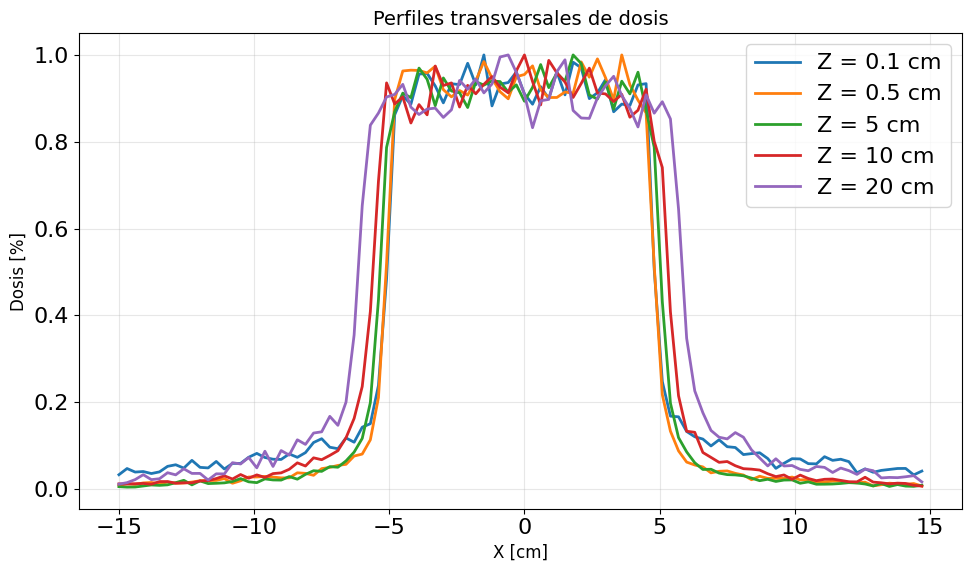

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 0.1 cm

perfil01_file_medio_3 = "Perfil01cm_03.csv"
datapf01_medio_3 = pd.read_csv(perfil01_file_medio_3, skiprows=8, header=None)
datapf01_medio_3.columns = ["X", "Y", "Z", "Dose"]
perfil01_data_medio_3 = datapf01_medio_3.groupby("X")["Dose"].mean().reset_index()
dose_max = perfil01_data_medio_3['Dose'].max()
perfil01_data_medio_3['Dose_normalized'] = perfil01_data_medio_3['Dose'] / dose_max

# 0.5 cm

perfil05_file_medio_3 = "Perfil05cm_03.csv"
datapf05_medio_3 = pd.read_csv(perfil05_file_medio_3, skiprows=8, header=None)
datapf05_medio_3.columns = ["X", "Y", "Z", "Dose"]
perfil05_data_medio_3 = datapf05_medio_3.groupby("X")["Dose"].mean().reset_index()
dose_max = perfil05_data_medio_3['Dose'].max()
perfil05_data_medio_3['Dose_normalized'] = perfil05_data_medio_3['Dose'] / dose_max

# 5 cm

perfil5_file_medio_3 = "Perfil5cm_03.csv"
datapf5_medio_3 = pd.read_csv(perfil5_file_medio_3, skiprows=8, header=None)
datapf5_medio_3.columns = ["X", "Y", "Z", "Dose"]
perfil5_data_medio_3 = datapf5_medio_3.groupby("X")["Dose"].mean().reset_index()
dose_max = perfil5_data_medio_3['Dose'].max()
perfil5_data_medio_3['Dose_normalized'] = perfil5_data_medio_3['Dose'] / dose_max

# 10 cm

perfil10_file_medio_3 = "Perfil10cm_03.csv"
datapf10_medio_3 = pd.read_csv(perfil10_file_medio_3, skiprows=8, header=None)
datapf10_medio_3.columns = ["X", "Y", "Z", "Dose"]
perfil10_data_medio_3 = datapf10_medio_3.groupby("X")["Dose"].mean().reset_index()
dose_max = perfil10_data_medio_3['Dose'].max()
perfil10_data_medio_3['Dose_normalized'] = perfil10_data_medio_3['Dose'] / dose_max

# 20 cm

perfil20_file_medio_3 = "Perfil20cm_03.csv"
datapf20_medio_3 = pd.read_csv(perfil20_file_medio_3, skiprows=8, header=None)
datapf20_medio_3.columns = ["X", "Y", "Z", "Dose"]
perfil20_data_medio_3 = datapf20_medio_3.groupby("X")["Dose"].mean().reset_index()
dose_max = perfil20_data_medio_3['Dose'].max()
perfil20_data_medio_3['Dose_normalized'] = perfil20_data_medio_3['Dose'] / dose_max


X = np.arange(-15, 15, 0.3)
plt.figure(figsize=(10, 6))
plt.plot(X, perfil01_data_medio_3['Dose_normalized'], label = "Z = 0.1 cm", linewidth=2)
plt.plot(X, perfil05_data_medio_3['Dose_normalized'], label = "Z = 0.5 cm", linewidth=2)
plt.plot(X, perfil5_data_medio_3['Dose_normalized'], label = "Z = 5 cm", linewidth=2)
plt.plot(X, perfil10_data_medio_3['Dose_normalized'], label = "Z = 10 cm", linewidth=2)
plt.plot(X, perfil20_data_medio_3['Dose_normalized'], label = "Z = 20 cm", linewidth=2)
plt.xlabel('X [cm]', fontsize=12)
plt.ylabel('Dosis [%]', fontsize=12)
plt.title('Perfiles transversales de dosis', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# "Varian_TrueBeam6MV_04"

PDD:

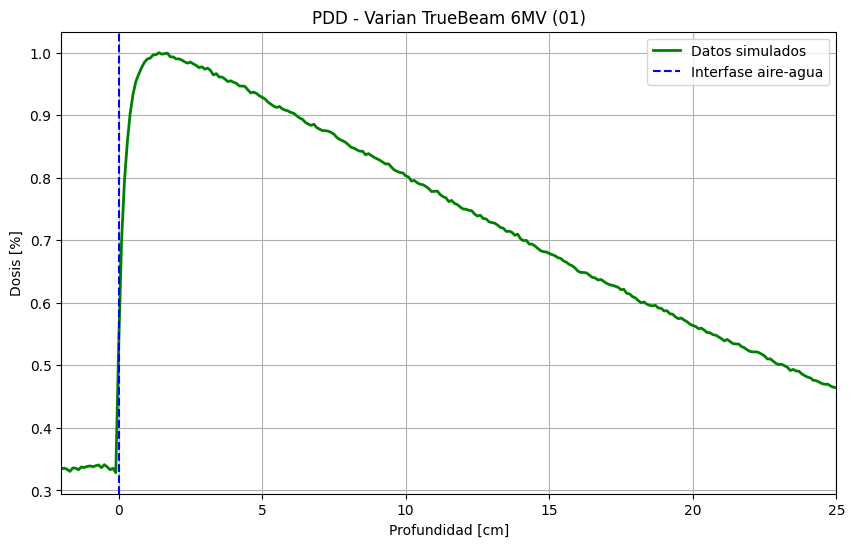

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pdd_file_medio_4 = "DosisAProfundidad_04.csv"
dataf_medio_4 = pd.read_csv(pdd_file_medio_4, skiprows = 8, header=None)
dataf_medio_4.columns = ["X", "Y", "Z", "Dose"]
pdd_data_medio_4 = dataf_medio_4.groupby("Z")["Dose"].mean().reset_index()

dose_max = pdd_data_medio_4['Dose'].max()
pdd_data_medio_4['Dose_normalized'] = pdd_data_medio_4['Dose'] / dose_max

Z = np.arange(-2, 30, 0.1)
plt.figure(figsize=(10, 6))
plt.plot(Z, pdd_data_medio_4['Dose_normalized'], linewidth = 2.0, color = "g", label = "Datos simulados")
plt.xlabel('Profundidad [cm]')
plt.ylabel('Dosis [%]')
plt.xlim(-2, 25)
plt.axvline(x = 0, color = 'b', linestyle = '--', label = 'Interfase aire-agua')
plt.title('PDD - Varian TrueBeam 6MV (01)')
plt.grid(True)
plt.legend()
plt.show()

PDD cerca a la interfase:

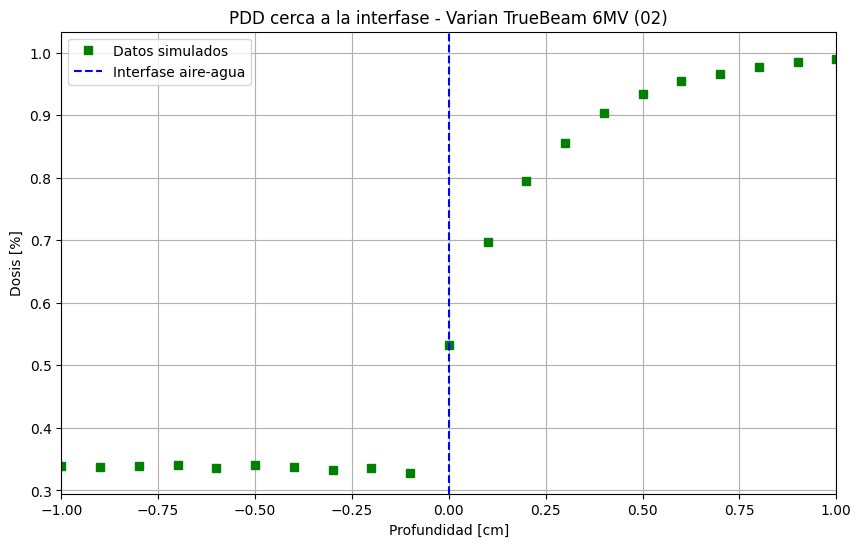

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(Z, pdd_data_medio_4['Dose_normalized'], "sg", label = "Datos simulados")
plt.xlabel('Profundidad [cm]')
plt.ylabel('Dosis [%]')
plt.xlim(-1, 1)
plt.axvline(x = 0, color = 'b', linestyle = '--', label = 'Interfase aire-agua')
plt.title('PDD cerca a la interfase - Varian TrueBeam 6MV (02)')
plt.grid(True)
plt.legend()
plt.show()

Mapa superficial de dosis:

Picos detectados: 1535 (15.350%)


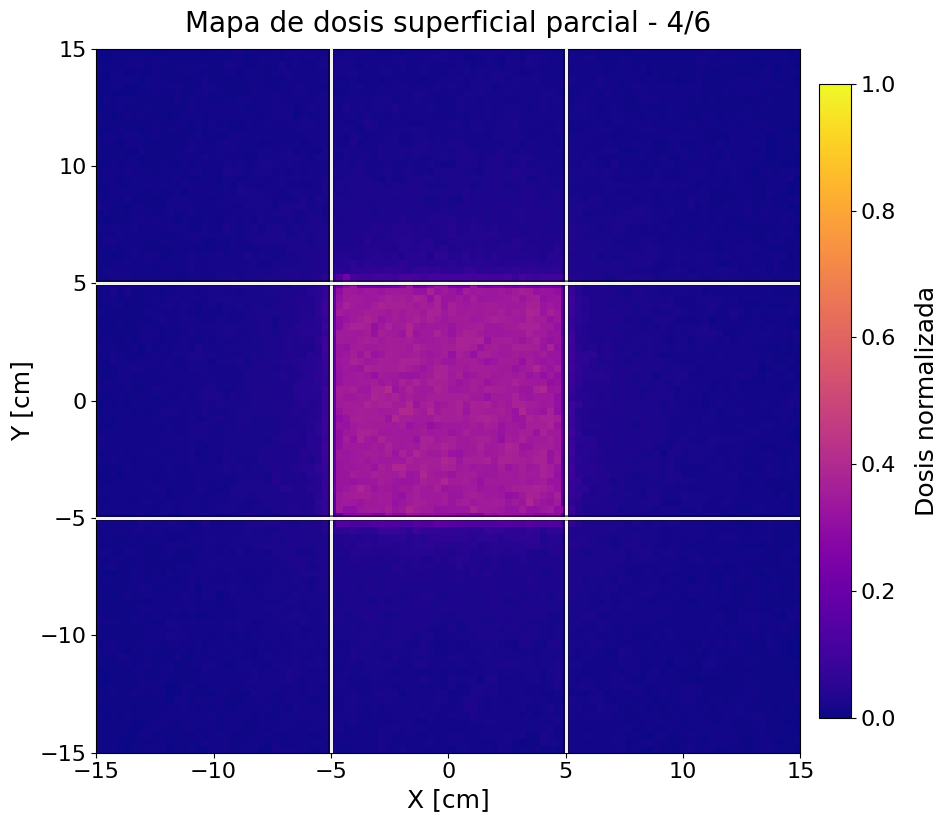

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as pe
from scipy.ndimage import median_filter, gaussian_filter

plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 20,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
})

def read_surfmap_csv(path, skiprows=8):
    """
    Lee un CSV de TOPAS (o similar) con 4 columnas: X,Y,Z,Dose y header textual.
    Ajusta skiprows si tu archivo tiene más/menos líneas de header.
    """
    df = pd.read_csv(path, skiprows=skiprows, header=None)
    df.columns = ["X", "Y", "Z", "Dose"]
    return df

def build_dose_matrix_single(df, x_col="X", y_col="Y", dose_col="Dose", normalize_mode="max"):
    """
    Construye una matriz 2D (Y vs X) con dosis normalizada en [0,1].
    normalize_mode:
      - "max": normaliza por el máximo global de Dose
      - "p99": normaliza por el percentil 99 (robusto si hay picos extremos)
    """
    df = df.copy()

    if normalize_mode == "p99":
        norm = np.nanpercentile(df[dose_col].to_numpy(dtype=float), 99)
        norm = norm if norm > 0 else df[dose_col].max()
    else:
        norm = df[dose_col].max()

    df["Dose_normalized"] = df[dose_col].to_numpy(dtype=float) / norm
    df["Dose_normalized"] = np.clip(df["Dose_normalized"], 0.0, 1.0)

    pivot = df.pivot(index=y_col, columns=x_col, values="Dose_normalized")
    pivot = pivot.sort_index(axis=0).sort_index(axis=1)

    matriz = pivot.to_numpy()
    x_unique = pivot.columns.to_numpy()
    y_unique = pivot.index.to_numpy()

    return df, matriz, x_unique, y_unique

def despike_matrix(matriz, window=4, z_thresh=6.0, mode="reflect"):
    """
    Detecta picos aislados con criterio robusto (mediana local + MAD local) y los reemplaza
    por la mediana local.
    """
    matriz = np.asarray(matriz, dtype=float)

    med = median_filter(matriz, size=window, mode=mode)
    resid = matriz - med
    mad = median_filter(np.abs(resid), size=window, mode=mode)

    eps = 1e-12
    robust_sigma = 1.4826 * mad + eps
    z = np.abs(resid) / robust_sigma

    spike_mask = z > z_thresh

    matriz_corr = matriz.copy()
    matriz_corr[spike_mask] = med[spike_mask]

    stats = {
        "n_spikes": int(spike_mask.sum()),
        "frac_spikes": float(spike_mask.mean()),
        "window": window,
        "z_thresh": z_thresh
    }
    return matriz_corr, spike_mask, stats



def plot_heatmap(matriz, title="", n_ticks=7, xlim=(-15, 15), ylim=(-15, 15),
                 save=True, out_png="MapaDosisSuperficial.png", dpi=600):
    """
    Heatmap con ejes físicos -15..15 (cm), colorbar [0,1] y líneas guía en ±5 cm.
    """
    matriz = np.asarray(matriz, dtype=float)
    matriz = np.clip(matriz, 0.0, 1.0)

    fig, ax = plt.subplots(figsize=(10.5, 8.5))

    im = ax.imshow(
        matriz,
        origin="lower",
        extent=[xlim[0], xlim[1], ylim[0], ylim[1]],
        cmap="plasma",
        vmin=0.0,
        vmax=1.0,
        aspect="equal",
        interpolation="nearest"
    )

    ax.set_title(title, pad=12)
    ax.set_xlabel("X [cm]")
    ax.set_ylabel("Y [cm]")

    ax.set_xticks(np.linspace(xlim[0], xlim[1], n_ticks))
    ax.set_yticks(np.linspace(ylim[0], ylim[1], n_ticks))

    cbar = fig.colorbar(im, ax=ax, shrink=0.9, pad=0.02)
    cbar.set_label("Dosis normalizada", rotation=90, labelpad=14)
    cbar.set_ticks(np.linspace(0, 1, 6))

    guide_style = dict(color="white", linewidth=2.2, alpha=0.95, linestyle="-", zorder=3)
    stroke = [pe.Stroke(linewidth=4.0, foreground="black", alpha=0.6), pe.Normal()]

    for x in (-5, 5):
        ln = ax.axvline(x=x, **guide_style)
        ln.set_path_effects(stroke)

    for y in (-5, 5):
        ln = ax.axhline(y=y, **guide_style)
        ln.set_path_effects(stroke)

    plt.tight_layout()

    if save:
        plt.savefig(out_png, dpi=dpi, bbox_inches="tight", facecolor="white")

    plt.show()

surfmap_file = "MapaSuperficial_04.csv"
df_raw = read_surfmap_csv(surfmap_file, skiprows=8)

surfmap_data_by_z = df_raw.groupby("Z")["Dose"].mean().reset_index()

df_norm, matriz, x_unique, y_unique = build_dose_matrix_single(
    df_raw,
    x_col="X",
    y_col="Y",
    dose_col="Dose",
    normalize_mode="max"
)

matriz_despiked, mask_spikes, stats = despike_matrix(matriz, window=2, z_thresh=1)
print(f"Picos detectados: {stats['n_spikes']} ({100*stats['frac_spikes']:.3f}%)")

matriz_corr = gaussian_filter(matriz_despiked, sigma=0.1, mode="reflect")
matriz_corr = np.clip(matriz_corr, 0.0, 1.0)

plot_heatmap(
    matriz_corr,
    title="Mapa de dosis superficial parcial - 4/6",
    n_ticks=7,
    xlim=(-15, 15),
    ylim=(-15, 15),
    save=True,
    out_png="MapaDosisSuperficial_04.png",
    dpi=600
)


Perfiles transversales:

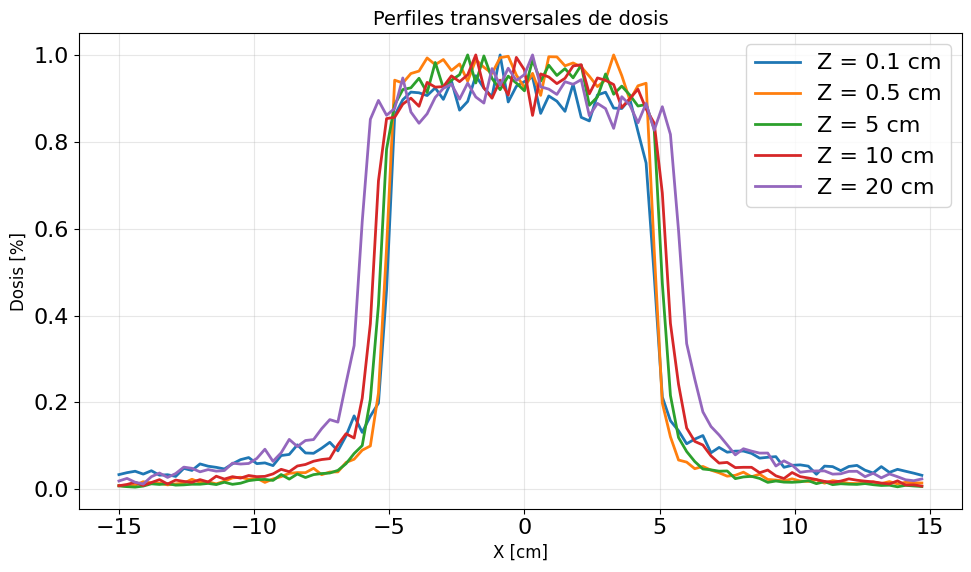

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 0.1 cm

perfil01_file_medio_4 = "Perfil01cm_04.csv"
datapf01_medio_4 = pd.read_csv(perfil01_file_medio_4, skiprows=8, header=None)
datapf01_medio_4.columns = ["X", "Y", "Z", "Dose"]
perfil01_data_medio_4 = datapf01_medio_4.groupby("X")["Dose"].mean().reset_index()
dose_max = perfil01_data_medio_4['Dose'].max()
perfil01_data_medio_4['Dose_normalized'] = perfil01_data_medio_4['Dose'] / dose_max

# 0.5 cm

perfil05_file_medio_4 = "Perfil05cm_04.csv"
datapf05_medio_4 = pd.read_csv(perfil05_file_medio_4, skiprows=8, header=None)
datapf05_medio_4.columns = ["X", "Y", "Z", "Dose"]
perfil05_data_medio_4 = datapf05_medio_4.groupby("X")["Dose"].mean().reset_index()
dose_max = perfil05_data_medio_4['Dose'].max()
perfil05_data_medio_4['Dose_normalized'] = perfil05_data_medio_4['Dose'] / dose_max

# 5 cm

perfil5_file_medio_4 = "Perfil5cm_04.csv"
datapf5_medio_4 = pd.read_csv(perfil5_file_medio_4, skiprows=8, header=None)
datapf5_medio_4.columns = ["X", "Y", "Z", "Dose"]
perfil5_data_medio_4 = datapf5_medio_4.groupby("X")["Dose"].mean().reset_index()
dose_max = perfil5_data_medio_4['Dose'].max()
perfil5_data_medio_4['Dose_normalized'] = perfil5_data_medio_4['Dose'] / dose_max

# 10 cm

perfil10_file_medio_4 = "Perfil10cm_04.csv"
datapf10_medio_4 = pd.read_csv(perfil10_file_medio_4, skiprows=8, header=None)
datapf10_medio_4.columns = ["X", "Y", "Z", "Dose"]
perfil10_data_medio_4 = datapf10_medio_4.groupby("X")["Dose"].mean().reset_index()
dose_max = perfil10_data_medio_4['Dose'].max()
perfil10_data_medio_4['Dose_normalized'] = perfil10_data_medio_4['Dose'] / dose_max

# 20 cm

perfil20_file_medio_4 = "Perfil20cm_04.csv"
datapf20_medio_4 = pd.read_csv(perfil20_file_medio_4, skiprows=8, header=None)
datapf20_medio_4.columns = ["X", "Y", "Z", "Dose"]
perfil20_data_medio_4 = datapf20_medio_4.groupby("X")["Dose"].mean().reset_index()
dose_max = perfil20_data_medio_4['Dose'].max()
perfil20_data_medio_4['Dose_normalized'] = perfil20_data_medio_4['Dose'] / dose_max


X = np.arange(-15, 15, 0.3)
plt.figure(figsize=(10, 6))
plt.plot(X, perfil01_data_medio_4['Dose_normalized'], label = "Z = 0.1 cm", linewidth=2)
plt.plot(X, perfil05_data_medio_4['Dose_normalized'], label = "Z = 0.5 cm", linewidth=2)
plt.plot(X, perfil5_data_medio_4['Dose_normalized'], label = "Z = 5 cm", linewidth=2)
plt.plot(X, perfil10_data_medio_4['Dose_normalized'], label = "Z = 10 cm", linewidth=2)
plt.plot(X, perfil20_data_medio_4['Dose_normalized'], label = "Z = 20 cm", linewidth=2)
plt.xlabel('X [cm]', fontsize=12)
plt.ylabel('Dosis [%]', fontsize=12)
plt.title('Perfiles transversales de dosis', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# "Varian_TrueBeam6MV_05"

PDD:

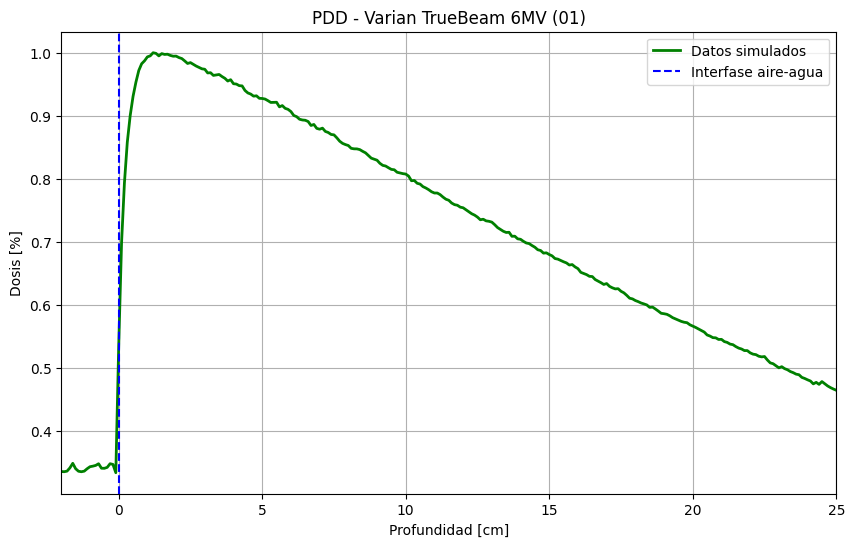

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pdd_file_medio_5 = "DosisAProfundidad_05.csv"
dataf_medio_5 = pd.read_csv(pdd_file_medio_5, skiprows = 8, header=None)
dataf_medio_5.columns = ["X", "Y", "Z", "Dose"]
pdd_data_medio_5 = dataf_medio_5.groupby("Z")["Dose"].mean().reset_index()

dose_max = pdd_data_medio_5['Dose'].max()
pdd_data_medio_5['Dose_normalized'] = pdd_data_medio_5['Dose'] / dose_max

Z = np.arange(-2, 30, 0.1)
plt.figure(figsize=(10, 6))
plt.plot(Z, pdd_data_medio_5['Dose_normalized'], linewidth = 2.0, color = "g", label = "Datos simulados")
plt.xlabel('Profundidad [cm]')
plt.ylabel('Dosis [%]')
plt.xlim(-2, 25)
plt.axvline(x = 0, color = 'b', linestyle = '--', label = 'Interfase aire-agua')
plt.title('PDD - Varian TrueBeam 6MV (01)')
plt.grid(True)
plt.legend()
plt.show()

PDD cerca a la interfase:

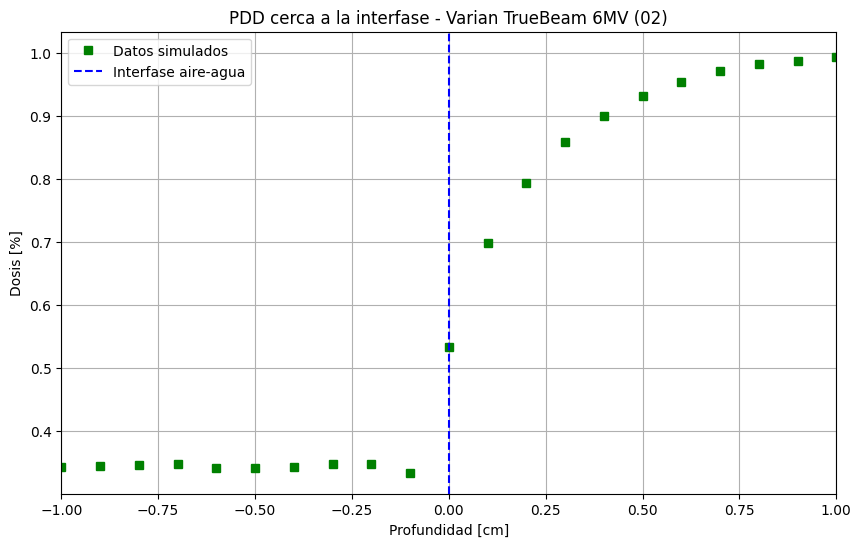

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(Z, pdd_data_medio_5['Dose_normalized'], "sg", label = "Datos simulados")
plt.xlabel('Profundidad [cm]')
plt.ylabel('Dosis [%]')
plt.xlim(-1, 1)
plt.axvline(x = 0, color = 'b', linestyle = '--', label = 'Interfase aire-agua')
plt.title('PDD cerca a la interfase - Varian TrueBeam 6MV (02)')
plt.grid(True)
plt.legend()
plt.show()

Mapa superficial de dosis:

Picos detectados: 463 (4.630%)


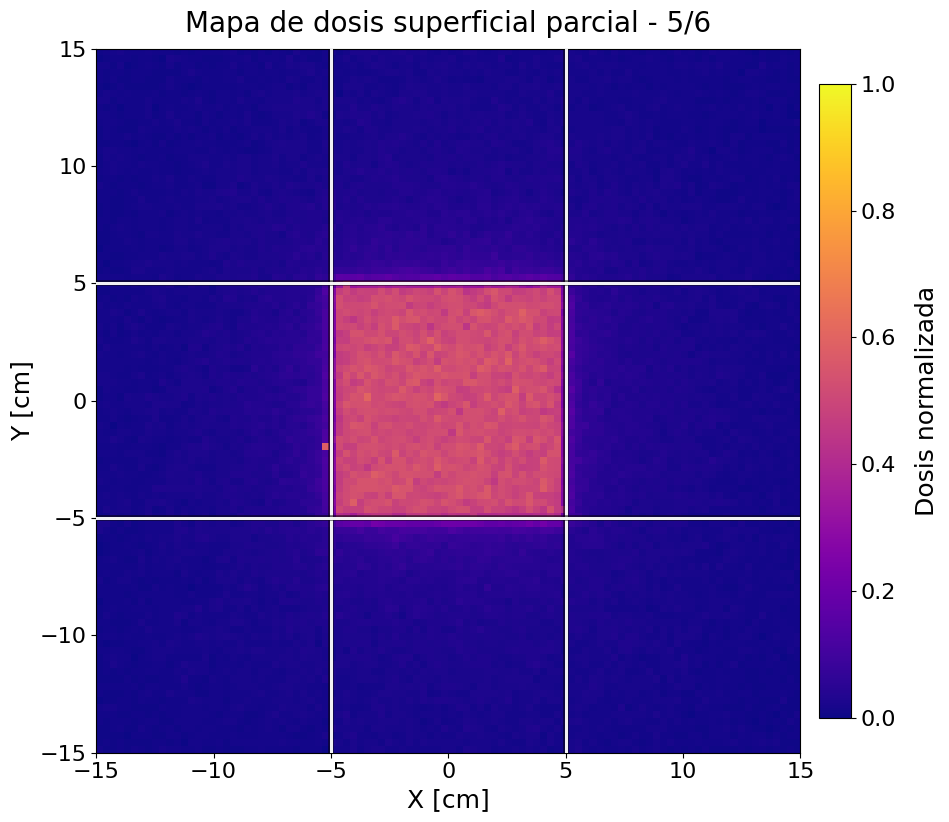

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as pe
from scipy.ndimage import median_filter, gaussian_filter

plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 20,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
})

def read_surfmap_csv(path, skiprows=8):
    """
    Lee un CSV de TOPAS (o similar) con 4 columnas: X,Y,Z,Dose y header textual.
    Ajusta skiprows si tu archivo tiene más/menos líneas de header.
    """
    df = pd.read_csv(path, skiprows=skiprows, header=None)
    df.columns = ["X", "Y", "Z", "Dose"]
    return df

def build_dose_matrix_single(df, x_col="X", y_col="Y", dose_col="Dose", normalize_mode="max"):
    """
    Construye una matriz 2D (Y vs X) con dosis normalizada en [0,1].
    normalize_mode:
      - "max": normaliza por el máximo global de Dose
      - "p99": normaliza por el percentil 99 (robusto si hay picos extremos)
    """
    df = df.copy()

    if normalize_mode == "p99":
        norm = np.nanpercentile(df[dose_col].to_numpy(dtype=float), 99)
        norm = norm if norm > 0 else df[dose_col].max()
    else:
        norm = df[dose_col].max()

    df["Dose_normalized"] = df[dose_col].to_numpy(dtype=float) / norm
    df["Dose_normalized"] = np.clip(df["Dose_normalized"], 0.0, 1.0)

    pivot = df.pivot(index=y_col, columns=x_col, values="Dose_normalized")
    pivot = pivot.sort_index(axis=0).sort_index(axis=1)

    matriz = pivot.to_numpy()
    x_unique = pivot.columns.to_numpy()
    y_unique = pivot.index.to_numpy()

    return df, matriz, x_unique, y_unique

def despike_matrix(matriz, window=4, z_thresh=6.0, mode="reflect"):
    """
    Detecta picos aislados con criterio robusto (mediana local + MAD local) y los reemplaza
    por la mediana local.
    """
    matriz = np.asarray(matriz, dtype=float)

    med = median_filter(matriz, size=window, mode=mode)
    resid = matriz - med
    mad = median_filter(np.abs(resid), size=window, mode=mode)

    eps = 1e-12
    robust_sigma = 1.4826 * mad + eps
    z = np.abs(resid) / robust_sigma

    spike_mask = z > z_thresh

    matriz_corr = matriz.copy()
    matriz_corr[spike_mask] = med[spike_mask]

    stats = {
        "n_spikes": int(spike_mask.sum()),
        "frac_spikes": float(spike_mask.mean()),
        "window": window,
        "z_thresh": z_thresh
    }
    return matriz_corr, spike_mask, stats

def plot_heatmap(matriz, title="", n_ticks=7, xlim=(-15, 15), ylim=(-15, 15),
                 save=True, out_png="MapaDosisSuperficial.png", dpi=600):
    """
    Heatmap con ejes físicos -15..15 (cm), colorbar [0,1] y líneas guía en ±5 cm.
    """
    matriz = np.asarray(matriz, dtype=float)
    matriz = np.clip(matriz, 0.0, 1.0)

    fig, ax = plt.subplots(figsize=(10.5, 8.5))

    im = ax.imshow(
        matriz,
        origin="lower",
        extent=[xlim[0], xlim[1], ylim[0], ylim[1]],
        cmap="plasma",
        vmin=0.0,
        vmax=1.0,
        aspect="equal",
        interpolation="nearest"
    )

    ax.set_title(title, pad=12)
    ax.set_xlabel("X [cm]")
    ax.set_ylabel("Y [cm]")

    ax.set_xticks(np.linspace(xlim[0], xlim[1], n_ticks))
    ax.set_yticks(np.linspace(ylim[0], ylim[1], n_ticks))

    cbar = fig.colorbar(im, ax=ax, shrink=0.9, pad=0.02)
    cbar.set_label("Dosis normalizada", rotation=90, labelpad=14)
    cbar.set_ticks(np.linspace(0, 1, 6))

    guide_style = dict(color="white", linewidth=2.2, alpha=0.95, linestyle="-", zorder=3)
    stroke = [pe.Stroke(linewidth=4.0, foreground="black", alpha=0.6), pe.Normal()]

    for x in (-5, 5):
        ln = ax.axvline(x=x, **guide_style)
        ln.set_path_effects(stroke)

    for y in (-5, 5):
        ln = ax.axhline(y=y, **guide_style)
        ln.set_path_effects(stroke)

    plt.tight_layout()

    if save:
        plt.savefig(out_png, dpi=dpi, bbox_inches="tight", facecolor="white")

    plt.show()

surfmap_file = "MapaSuperficial_05.csv"
df_raw = read_surfmap_csv(surfmap_file, skiprows=8)

surfmap_data_by_z = df_raw.groupby("Z")["Dose"].mean().reset_index()

df_norm, matriz, x_unique, y_unique = build_dose_matrix_single(
    df_raw,
    x_col="X",
    y_col="Y",
    dose_col="Dose",
    normalize_mode="max"
)

matriz_despiked, mask_spikes, stats = despike_matrix(matriz, window=2, z_thresh=2.5)
print(f"Picos detectados: {stats['n_spikes']} ({100*stats['frac_spikes']:.3f}%)")

matriz_corr = gaussian_filter(matriz_despiked, sigma=0.1, mode="reflect")
matriz_corr = np.clip(matriz_corr, 0.0, 1.0)

plot_heatmap(
    matriz_corr,
    title="Mapa de dosis superficial parcial - 5/6",
    n_ticks=7,
    xlim=(-15, 15),
    ylim=(-15, 15),
    save=True,
    out_png="MapaDosisSuperficial_05.png",
    dpi=600
)


Perfiles transversales:

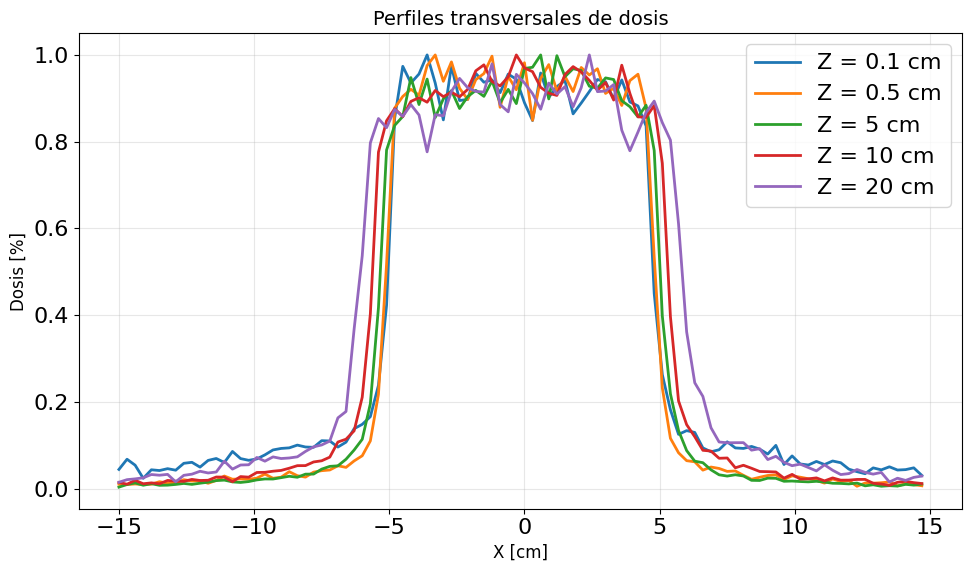

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 0.1 cm

perfil01_file_medio_5 = "Perfil01cm_05.csv"
datapf01_medio_5 = pd.read_csv(perfil01_file_medio_5, skiprows=8, header=None)
datapf01_medio_5.columns = ["X", "Y", "Z", "Dose"]
perfil01_data_medio_5 = datapf01_medio_5.groupby("X")["Dose"].mean().reset_index()
dose_max = perfil01_data_medio_5['Dose'].max()
perfil01_data_medio_5['Dose_normalized'] = perfil01_data_medio_5['Dose'] / dose_max

# 0.5 cm

perfil05_file_medio_5 = "Perfil05cm_05.csv"
datapf05_medio_5 = pd.read_csv(perfil05_file_medio_5, skiprows=8, header=None)
datapf05_medio_5.columns = ["X", "Y", "Z", "Dose"]
perfil05_data_medio_5 = datapf05_medio_5.groupby("X")["Dose"].mean().reset_index()
dose_max = perfil05_data_medio_5['Dose'].max()
perfil05_data_medio_5['Dose_normalized'] = perfil05_data_medio_5['Dose'] / dose_max

# 5 cm

perfil5_file_medio_5 = "Perfil5cm_05.csv"
datapf5_medio_5 = pd.read_csv(perfil5_file_medio_5, skiprows=8, header=None)
datapf5_medio_5.columns = ["X", "Y", "Z", "Dose"]
perfil5_data_medio_5 = datapf5_medio_5.groupby("X")["Dose"].mean().reset_index()
dose_max = perfil5_data_medio_5['Dose'].max()
perfil5_data_medio_5['Dose_normalized'] = perfil5_data_medio_5['Dose'] / dose_max

# 10 cm

perfil10_file_medio_5 = "Perfil10cm_05.csv"
datapf10_medio_5 = pd.read_csv(perfil10_file_medio_5, skiprows=8, header=None)
datapf10_medio_5.columns = ["X", "Y", "Z", "Dose"]
perfil10_data_medio_5 = datapf10_medio_5.groupby("X")["Dose"].mean().reset_index()
dose_max = perfil10_data_medio_5['Dose'].max()
perfil10_data_medio_5['Dose_normalized'] = perfil10_data_medio_5['Dose'] / dose_max

# 20 cm

perfil20_file_medio_5 = "Perfil20cm_05.csv"
datapf20_medio_5 = pd.read_csv(perfil20_file_medio_5, skiprows=8, header=None)
datapf20_medio_5.columns = ["X", "Y", "Z", "Dose"]
perfil20_data_medio_5 = datapf20_medio_5.groupby("X")["Dose"].mean().reset_index()
dose_max = perfil20_data_medio_5['Dose'].max()
perfil20_data_medio_5['Dose_normalized'] = perfil20_data_medio_5['Dose'] / dose_max


X = np.arange(-15, 15, 0.3)
plt.figure(figsize=(10, 6))
plt.plot(X, perfil01_data_medio_5['Dose_normalized'], label = "Z = 0.1 cm", linewidth=2)
plt.plot(X, perfil05_data_medio_5['Dose_normalized'], label = "Z = 0.5 cm", linewidth=2)
plt.plot(X, perfil5_data_medio_5['Dose_normalized'], label = "Z = 5 cm", linewidth=2)
plt.plot(X, perfil10_data_medio_5['Dose_normalized'], label = "Z = 10 cm", linewidth=2)
plt.plot(X, perfil20_data_medio_5['Dose_normalized'], label = "Z = 20 cm", linewidth=2)
plt.xlabel('X [cm]', fontsize=12)
plt.ylabel('Dosis [%]', fontsize=12)
plt.title('Perfiles transversales de dosis', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# "Varian_TrueBeam6MV_06"

PDD:

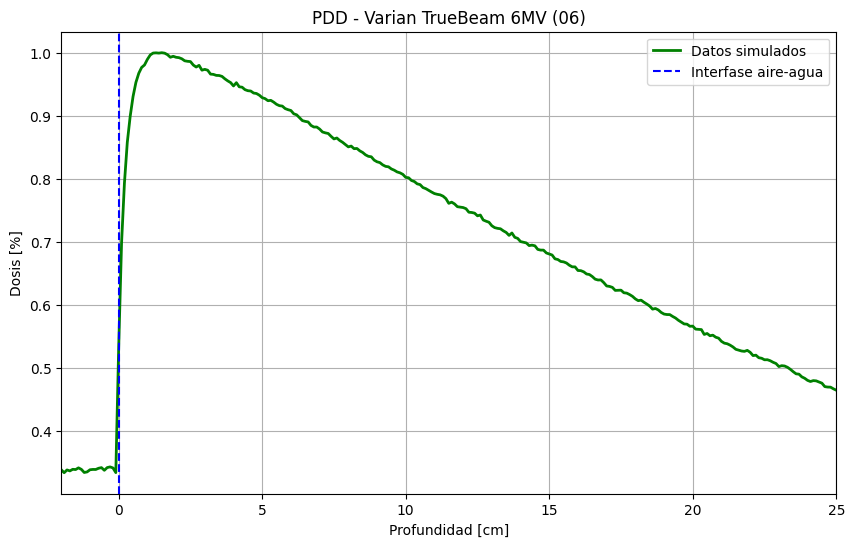

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pdd_file_medio_6 = "DosisAProfundidad_06.csv"
dataf_medio_6 = pd.read_csv(pdd_file_medio_6, skiprows = 8, header=None)
dataf_medio_6.columns = ["X", "Y", "Z", "Dose"]
pdd_data_medio_6 = dataf_medio_6.groupby("Z")["Dose"].mean().reset_index()

dose_max = pdd_data_medio_6['Dose'].max()
pdd_data_medio_6['Dose_normalized'] = pdd_data_medio_6['Dose'] / dose_max

Z = np.arange(-2, 30, 0.1)
plt.figure(figsize=(10, 6))
plt.plot(Z, pdd_data_medio_6['Dose_normalized'], linewidth = 2.0, color = "g", label = "Datos simulados")
plt.xlabel('Profundidad [cm]')
plt.ylabel('Dosis [%]')
plt.xlim(-2, 25)
plt.axvline(x = 0, color = 'b', linestyle = '--', label = 'Interfase aire-agua')
plt.title('PDD - Varian TrueBeam 6MV (06)')
plt.grid(True)
plt.legend()
plt.show()

PDD cerca a la interfase:

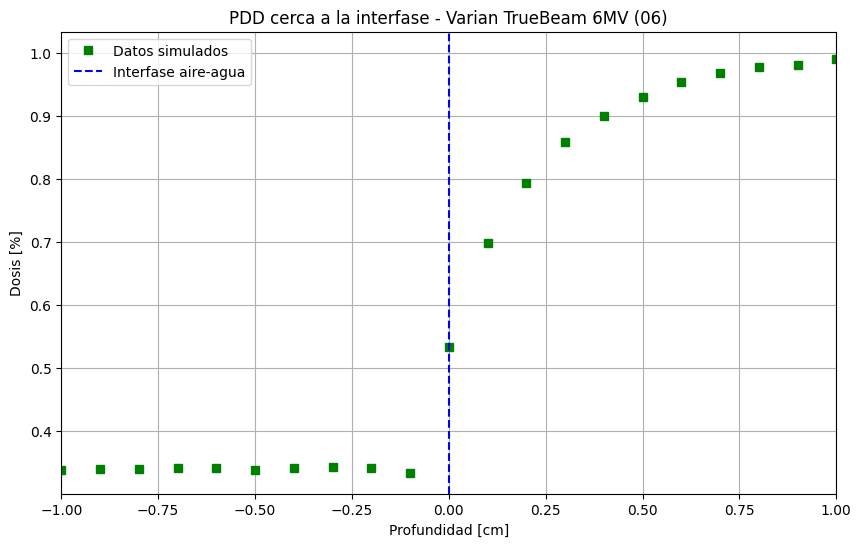

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(Z, pdd_data_medio_6['Dose_normalized'], "sg", label = "Datos simulados")
plt.xlabel('Profundidad [cm]')
plt.ylabel('Dosis [%]')
plt.xlim(-1, 1)
plt.axvline(x = 0, color = 'b', linestyle = '--', label = 'Interfase aire-agua')
plt.title('PDD cerca a la interfase - Varian TrueBeam 6MV (06)')
plt.grid(True)
plt.legend()
plt.show()

Mapa superficial de dosis:

Picos detectados: 505 (5.050%)


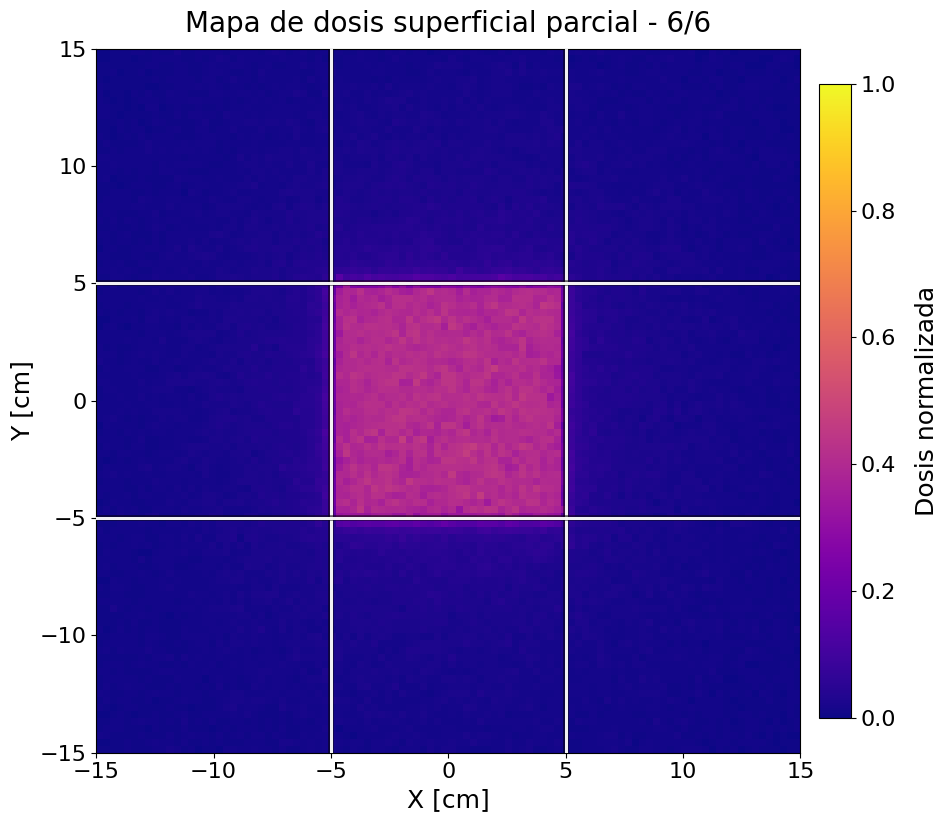

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as pe

from scipy.ndimage import median_filter, gaussian_filter

plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 20,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
})

def read_surfmap_csv(path, skiprows=8):
    """
    Lee un CSV de TOPAS (o similar) con 4 columnas: X,Y,Z,Dose y header textual.
    Ajusta skiprows si tu archivo tiene más/menos líneas de header.
    """
    df = pd.read_csv(path, skiprows=skiprows, header=None)
    df.columns = ["X", "Y", "Z", "Dose"]
    return df

def build_dose_matrix_single(df, x_col="X", y_col="Y", dose_col="Dose", normalize_mode="max"):
    """
    Construye una matriz 2D (Y vs X) con dosis normalizada en [0,1].
    normalize_mode:
      - "max": normaliza por el máximo global de Dose
      - "p99": normaliza por el percentil 99 (robusto si hay picos extremos)
    """
    df = df.copy()

    if normalize_mode == "p99":
        norm = np.nanpercentile(df[dose_col].to_numpy(dtype=float), 99)
        norm = norm if norm > 0 else df[dose_col].max()
    else:
        norm = df[dose_col].max()

    df["Dose_normalized"] = df[dose_col].to_numpy(dtype=float) / norm
    df["Dose_normalized"] = np.clip(df["Dose_normalized"], 0.0, 1.0)

    pivot = df.pivot(index=y_col, columns=x_col, values="Dose_normalized")
    pivot = pivot.sort_index(axis=0).sort_index(axis=1)

    matriz = pivot.to_numpy()
    x_unique = pivot.columns.to_numpy()
    y_unique = pivot.index.to_numpy()

    return df, matriz, x_unique, y_unique

def despike_matrix(matriz, window=4, z_thresh=6.0, mode="reflect"):
    """
    Detecta picos aislados con criterio robusto (mediana local + MAD local) y los reemplaza
    por la mediana local.
    """
    matriz = np.asarray(matriz, dtype=float)

    med = median_filter(matriz, size=window, mode=mode)
    resid = matriz - med
    mad = median_filter(np.abs(resid), size=window, mode=mode)

    eps = 1e-12
    robust_sigma = 1.4826 * mad + eps
    z = np.abs(resid) / robust_sigma

    spike_mask = z > z_thresh

    matriz_corr = matriz.copy()
    matriz_corr[spike_mask] = med[spike_mask]

    stats = {
        "n_spikes": int(spike_mask.sum()),
        "frac_spikes": float(spike_mask.mean()),
        "window": window,
        "z_thresh": z_thresh
    }
    return matriz_corr, spike_mask, stats

def plot_heatmap(matriz, title="", n_ticks=7, xlim=(-15, 15), ylim=(-15, 15),
                 save=True, out_png="MapaDosisSuperficial.png", dpi=600):
    """
    Heatmap con ejes físicos -15..15 (cm), colorbar [0,1] y líneas guía en ±5 cm.
    """
    matriz = np.asarray(matriz, dtype=float)
    matriz = np.clip(matriz, 0.0, 1.0)

    fig, ax = plt.subplots(figsize=(10.5, 8.5))

    im = ax.imshow(
        matriz,
        origin="lower",
        extent=[xlim[0], xlim[1], ylim[0], ylim[1]],
        cmap="plasma",
        vmin=0.0,
        vmax=1.0,
        aspect="equal",
        interpolation="nearest"
    )

    ax.set_title(title, pad=12)
    ax.set_xlabel("X [cm]")
    ax.set_ylabel("Y [cm]")

    ax.set_xticks(np.linspace(xlim[0], xlim[1], n_ticks))
    ax.set_yticks(np.linspace(ylim[0], ylim[1], n_ticks))

    cbar = fig.colorbar(im, ax=ax, shrink=0.9, pad=0.02)
    cbar.set_label("Dosis normalizada", rotation=90, labelpad=14)
    cbar.set_ticks(np.linspace(0, 1, 6))

    guide_style = dict(color="white", linewidth=2.2, alpha=0.95, linestyle="-", zorder=3)
    stroke = [pe.Stroke(linewidth=4.0, foreground="black", alpha=0.6), pe.Normal()]

    for x in (-5, 5):
        ln = ax.axvline(x=x, **guide_style)
        ln.set_path_effects(stroke)

    for y in (-5, 5):
        ln = ax.axhline(y=y, **guide_style)
        ln.set_path_effects(stroke)

    plt.tight_layout()

    if save:
        plt.savefig(out_png, dpi=dpi, bbox_inches="tight", facecolor="white")

    plt.show()

surfmap_file = "MapaSuperficial_06.csv"
df_raw = read_surfmap_csv(surfmap_file, skiprows=8)

surfmap_data_by_z = df_raw.groupby("Z")["Dose"].mean().reset_index()

df_norm, matriz, x_unique, y_unique = build_dose_matrix_single(
    df_raw,
    x_col="X",
    y_col="Y",
    dose_col="Dose",
    normalize_mode="max"
)

matriz_despiked, mask_spikes, stats = despike_matrix(matriz, window=2, z_thresh=2.5)
print(f"Picos detectados: {stats['n_spikes']} ({100*stats['frac_spikes']:.3f}%)")

matriz_corr = gaussian_filter(matriz_despiked, sigma=0.1, mode="reflect")
matriz_corr = np.clip(matriz_corr, 0.0, 1.0)

plot_heatmap(
    matriz_corr,
    title="Mapa de dosis superficial parcial - 6/6",
    n_ticks=7,
    xlim=(-15, 15),
    ylim=(-15, 15),
    save=True,
    out_png="MapaDosisSuperficial_06.png",
    dpi=600
)


Perfiles transversales:

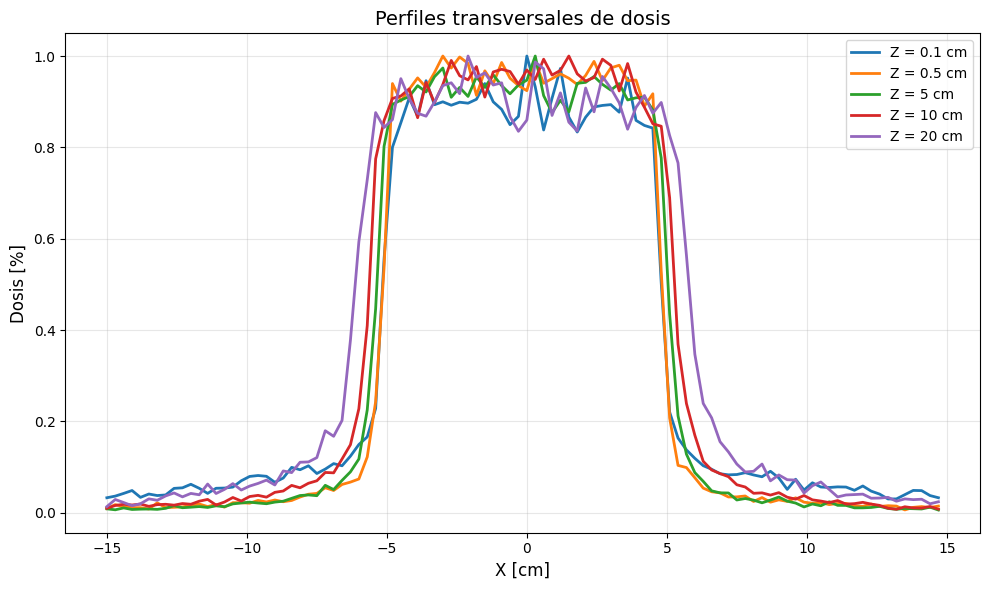

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 0.1 cm

perfil01_file_medio_6 = "Perfil01cm_06.csv"
datapf01_medio_6 = pd.read_csv(perfil01_file_medio_6, skiprows=8, header=None)
datapf01_medio_6.columns = ["X", "Y", "Z", "Dose"]
perfil01_data_medio_6 = datapf01_medio_6.groupby("X")["Dose"].mean().reset_index()
dose_max = perfil01_data_medio_6['Dose'].max()
perfil01_data_medio_6['Dose_normalized'] = perfil01_data_medio_6['Dose'] / dose_max

# 0.5 cm

perfil05_file_medio_6 = "Perfil05cm_06.csv"
datapf05_medio_6 = pd.read_csv(perfil05_file_medio_6, skiprows=8, header=None)
datapf05_medio_6.columns = ["X", "Y", "Z", "Dose"]
perfil05_data_medio_6 = datapf05_medio_6.groupby("X")["Dose"].mean().reset_index()
dose_max = perfil05_data_medio_6['Dose'].max()
perfil05_data_medio_6['Dose_normalized'] = perfil05_data_medio_6['Dose'] / dose_max

# 5 cm

perfil5_file_medio_6 = "Perfil5cm_06.csv"
datapf5_medio_6 = pd.read_csv(perfil5_file_medio_6, skiprows=8, header=None)
datapf5_medio_6.columns = ["X", "Y", "Z", "Dose"]
perfil5_data_medio_6 = datapf5_medio_6.groupby("X")["Dose"].mean().reset_index()
dose_max = perfil5_data_medio_6['Dose'].max()
perfil5_data_medio_6['Dose_normalized'] = perfil5_data_medio_6['Dose'] / dose_max

# 10 cm

perfil10_file_medio_6 = "Perfil10cm_06.csv"
datapf10_medio_6 = pd.read_csv(perfil10_file_medio_6, skiprows=8, header=None)
datapf10_medio_6.columns = ["X", "Y", "Z", "Dose"]
perfil10_data_medio_6 = datapf10_medio_6.groupby("X")["Dose"].mean().reset_index()
dose_max = perfil10_data_medio_6['Dose'].max()
perfil10_data_medio_6['Dose_normalized'] = perfil10_data_medio_6['Dose'] / dose_max

# 20 cm

perfil20_file_medio_6 = "Perfil20cm_06.csv"
datapf20_medio_6 = pd.read_csv(perfil20_file_medio_6, skiprows=8, header=None)
datapf20_medio_6.columns = ["X", "Y", "Z", "Dose"]
perfil20_data_medio_6 = datapf20_medio_6.groupby("X")["Dose"].mean().reset_index()
dose_max = perfil20_data_medio_6['Dose'].max()
perfil20_data_medio_6['Dose_normalized'] = perfil20_data_medio_6['Dose'] / dose_max


X = np.arange(-15, 15, 0.3)
plt.figure(figsize=(10, 6))
plt.plot(X, perfil01_data_medio_6['Dose_normalized'], label = "Z = 0.1 cm", linewidth=2)
plt.plot(X, perfil05_data_medio_6['Dose_normalized'], label = "Z = 0.5 cm", linewidth=2)
plt.plot(X, perfil5_data_medio_6['Dose_normalized'], label = "Z = 5 cm", linewidth=2)
plt.plot(X, perfil10_data_medio_6['Dose_normalized'], label = "Z = 10 cm", linewidth=2)
plt.plot(X, perfil20_data_medio_6['Dose_normalized'], label = "Z = 20 cm", linewidth=2)
plt.xlabel('X [cm]', fontsize=12)
plt.ylabel('Dosis [%]', fontsize=12)
plt.title('Perfiles transversales de dosis', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# PDD - Datos unificados:

PDD

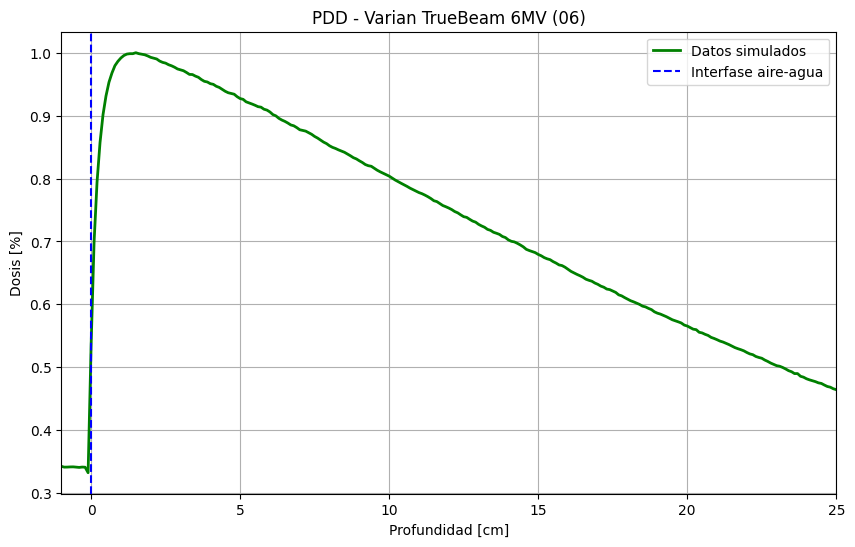

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pdd_suma_medio = pd.DataFrame()
pdd_suma_medio['Dose'] = pdd_data_medio_1['Dose'] + pdd_data_medio_2['Dose'] + pdd_data_medio_3['Dose'] + pdd_data_medio_4['Dose'] + pdd_data_medio_5['Dose'] + pdd_data_medio_6['Dose']

dose_max_pdd = pdd_suma_medio['Dose'].max()
pdd_suma_medio['Dose_normalized'] = pdd_suma_medio['Dose'] / dose_max_pdd

Z = np.arange(-2, 30, 0.1)
plt.figure(figsize=(10, 6))
plt.plot(Z, pdd_suma_medio['Dose_normalized'], linewidth = 2.0, color = "g", label = "Datos simulados")
plt.xlabel('Profundidad [cm]')
plt.ylabel('Dosis [%]')
plt.xlim(-1, 25)
plt.axvline(x = 0, color = 'b', linestyle = '--', label = 'Interfase aire-agua')
plt.title('PDD - Varian TrueBeam 6MV (06)')
plt.grid(True)
plt.legend()
plt.show()

PDD cerca a la interfase:

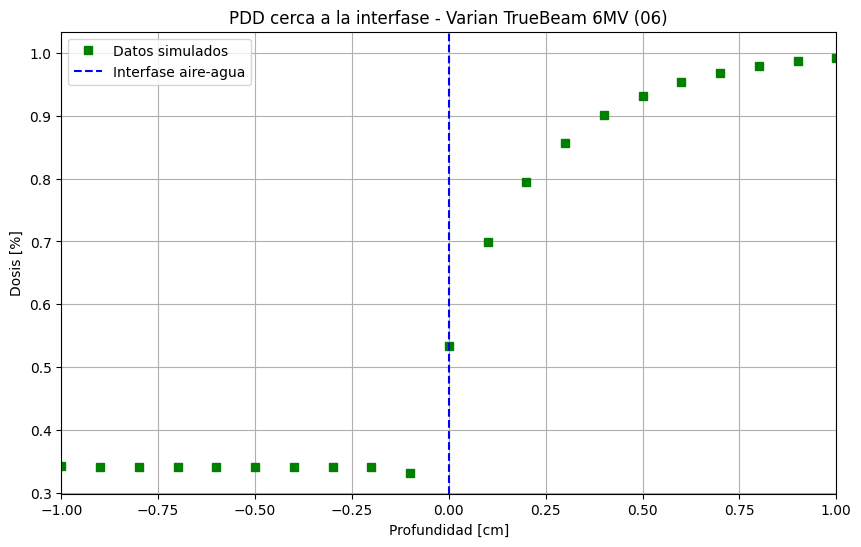

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(Z, pdd_suma_medio['Dose_normalized'], "sg", label = "Datos simulados")
plt.xlabel('Profundidad [cm]')
plt.ylabel('Dosis [%]')
plt.xlim(-1, 1)
plt.axvline(x = 0, color = 'b', linestyle = '--', label = 'Interfase aire-agua')
plt.title('PDD cerca a la interfase - Varian TrueBeam 6MV (06)')
plt.grid(True)
plt.legend()
plt.show()

Mapa superficial de dosis:

Picos detectados: 39 (0.390%)


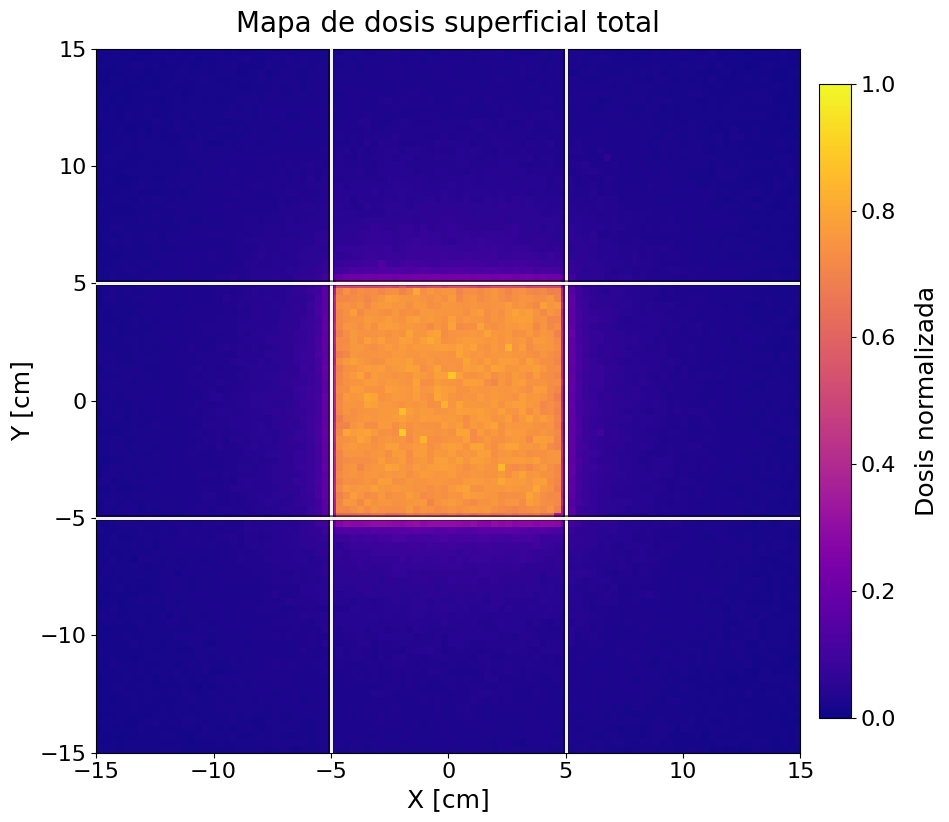

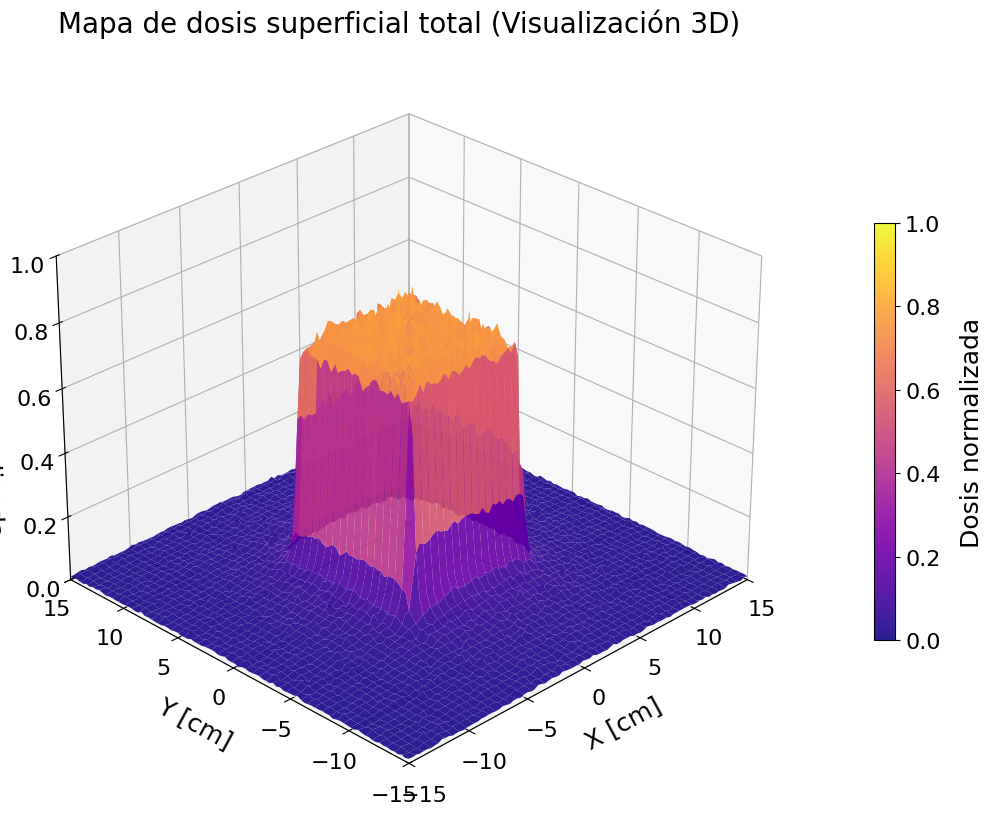

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as pe

from scipy.ndimage import median_filter, gaussian_filter

plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 20,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
})


def build_dose_matrix(datasf_list, x_col="X", y_col="Y", dose_col="Dose"):
    """
    Suma N dataframes con columnas X,Y,Dose y devuelve:
      - surfmap_sum: dataframe con X,Y,Dose,Dose_normalized
      - matriz_sum: matriz 2D (Y index, X columns) con dosis normalizada
      - x_unique, y_unique: ejes ordenados reales (en las unidades de tus X,Y)
    """
    base = datasf_list[0][[x_col, y_col]].copy()
    dose_sum = np.zeros(len(base), dtype=float)

    for df in datasf_list:
        dose_sum += df[dose_col].to_numpy(dtype=float)

    surfmap_sum = base.copy()
    surfmap_sum["Dose"] = dose_sum

    dose_max = surfmap_sum["Dose"].max()
    surfmap_sum["Dose_normalized"] = surfmap_sum["Dose"] / dose_max

    pivot = surfmap_sum.pivot(index=y_col, columns=x_col, values="Dose_normalized")
    pivot = pivot.sort_index(axis=0).sort_index(axis=1)

    matriz_sum = pivot.to_numpy()
    x_unique = pivot.columns.to_numpy()
    y_unique = pivot.index.to_numpy()

    return surfmap_sum, matriz_sum, x_unique, y_unique


def despike_matrix(matriz, window=5, z_thresh=6.0, mode="reflect"):
    """
    Detecta picos aislados con criterio robusto (mediana local + MAD local) y los reemplaza
    por la mediana local.
    """
    matriz = np.asarray(matriz, dtype=float)

    med = median_filter(matriz, size=window, mode=mode)
    resid = matriz - med
    mad = median_filter(np.abs(resid), size=window, mode=mode)

    eps = 1e-12
    robust_sigma = 1.4826 * mad + eps
    z = np.abs(resid) / robust_sigma

    spike_mask = z > z_thresh

    matriz_corr = matriz.copy()
    matriz_corr[spike_mask] = med[spike_mask]

    stats = {
        "n_spikes": int(spike_mask.sum()),
        "frac_spikes": float(spike_mask.mean()),
        "window": window,
        "z_thresh": z_thresh
    }
    return matriz_corr, spike_mask, stats


def plot_heatmap(matriz, title="", n_ticks=7, xlim=(-15, 15), ylim=(-15, 15)):
    """
    Heatmap con ejes físicos rotulados -15..15 (cm), colorbar fijada en [0,1],
    y líneas guía en x=±5 cm, y=±5 cm.
    """
    matriz = np.asarray(matriz, dtype=float)

    fig, ax = plt.subplots(figsize=(10.5, 8.5))

    im = ax.imshow(
        matriz,
        origin="lower",
        extent=[xlim[0], xlim[1], ylim[0], ylim[1]],
        cmap="plasma",
        vmin=0.0,
        vmax=1.0,
        aspect="equal",
        interpolation="nearest"
    )

    ax.set_title(title, pad=12)
    ax.set_xlabel("X [cm]")
    ax.set_ylabel("Y [cm]")

    ax.set_xticks(np.linspace(xlim[0], xlim[1], n_ticks))
    ax.set_yticks(np.linspace(ylim[0], ylim[1], n_ticks))

    cbar = fig.colorbar(im, ax=ax, shrink=0.9, pad=0.02)
    cbar.set_label("Dosis normalizada", rotation=90, labelpad=14)
    cbar.set_ticks(np.linspace(0, 1, 6))
    guide_style = dict(color="white", linewidth=2.2, alpha=0.95, linestyle="-", zorder=3)
    stroke = [pe.Stroke(linewidth=4.0, foreground="black", alpha=0.6), pe.Normal()]

    for x in (-5, 5):
        ln = ax.axvline(x=x, **guide_style)
        ln.set_path_effects(stroke)

    for y in (-5, 5):
        ln = ax.axhline(y=y, **guide_style)
        ln.set_path_effects(stroke)

    plt.tight_layout()
    plt.savefig("MapaDosisSuperficialTotal.png", dpi=600)
    plt.show()


def plot_surface_3d(matriz, title="", n_ticks=7, xlim=(-15, 15), ylim=(-15, 15)):
    """
    Superficie 3D con ejes X,Y en cm (-15..15) y eje Z fijado a [0,1].
    """
    matriz = np.asarray(matriz, dtype=float)

    fig = plt.figure(figsize=(12.5, 8.5))
    ax = fig.add_subplot(111, projection="3d")

    n_y, n_x = matriz.shape

    x = np.linspace(xlim[0], xlim[1], n_x)
    y = np.linspace(ylim[0], ylim[1], n_y)
    X, Y = np.meshgrid(x, y)

    surf = ax.plot_surface(
        X, Y, matriz,
        cmap="plasma",
        vmin=0.0,
        vmax=1.0,
        linewidth=0,
        antialiased=True,
        alpha=0.9
    )

    ax.set_title(title, pad=14)
    ax.set_xlabel("X [cm]", labelpad=10)
    ax.set_ylabel("Y [cm]", labelpad=10)
    ax.set_zlabel("Dosis normalizada", labelpad=10)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(0.0, 1.0)

    ax.set_xticks(np.linspace(xlim[0], xlim[1], n_ticks))
    ax.set_yticks(np.linspace(ylim[0], ylim[1], n_ticks))
    ax.set_zticks(np.linspace(0, 1, 6))

    cbar = fig.colorbar(surf, ax=ax, shrink=0.55, pad=0.08)
    cbar.set_label("Dosis normalizada", labelpad=14)
    cbar.set_ticks(np.linspace(0, 1, 6))

    ax.view_init(elev=28, azim=-135)

    plt.tight_layout()
    plt.savefig("MapaDosis3D.png", dpi=600)
    plt.show()

datasf_list = [
    datasf_file_medio_1,
    datasf_file_medio_2,
    datasf_file_medio_3,
    datasf_file_medio_4,
    datasf_file_medio_5,
    datasf_file_medio_6
]

surfmap_sum, matriz_sum, x_unique, y_unique = build_dose_matrix(datasf_list)

matriz_despiked, mask_spikes, stats = despike_matrix(matriz_sum, window=4, z_thresh=6.0)
print(f"Picos detectados: {stats['n_spikes']} ({100*stats['frac_spikes']:.3f}%)")

matriz_corr = gaussian_filter(matriz_despiked, sigma=0.1, mode="reflect")

plot_heatmap(
    matriz_corr,
    title="Mapa de dosis superficial total",
    n_ticks=7,
    xlim=(-15, 15),
    ylim=(-15, 15)
)

plot_surface_3d(
    matriz_corr,
    title="Mapa de dosis superficial total (Visualización 3D)",
    n_ticks=7,
    xlim=(-15, 15),
    ylim=(-15, 15)
)


Perfiles transversales:

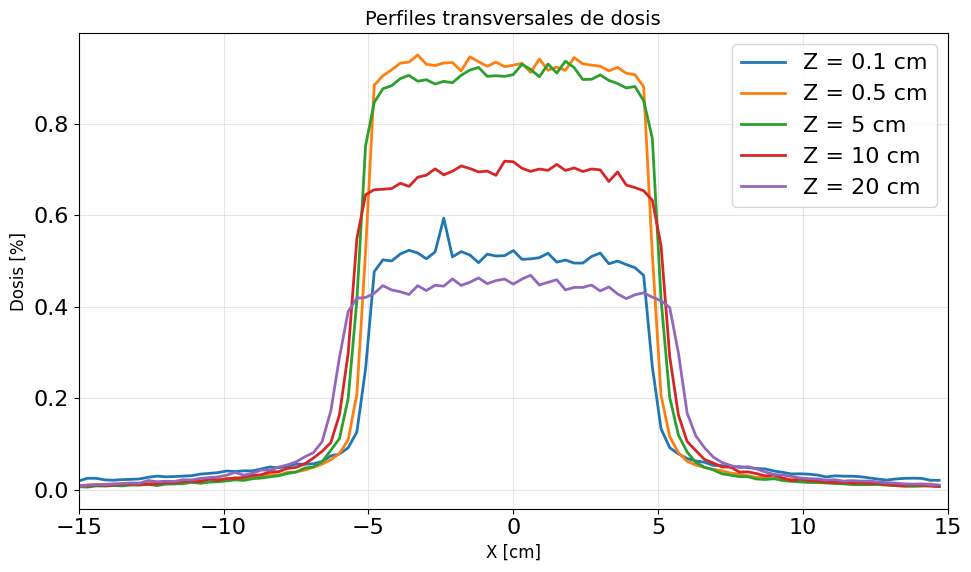

In [ ]:
perfil01_suma_medio = pd.DataFrame()
perfil01_suma_medio['Dose'] = perfil01_data_medio_1['Dose'] + perfil01_data_medio_2['Dose'] + perfil01_data_medio_3['Dose'] + perfil01_data_medio_4['Dose'] + perfil01_data_medio_5['Dose'] + perfil01_data_medio_6['Dose']

perfil05_suma_medio = pd.DataFrame()
perfil05_suma_medio['Dose'] = perfil05_data_medio_1['Dose'] + perfil05_data_medio_2['Dose'] + perfil05_data_medio_3['Dose'] + perfil05_data_medio_4['Dose'] + perfil05_data_medio_5['Dose'] + perfil05_data_medio_6['Dose']

perfil5_suma_medio = pd.DataFrame()
perfil5_suma_medio['Dose'] = perfil5_data_medio_1['Dose'] + perfil5_data_medio_2['Dose'] + perfil5_data_medio_3['Dose'] + perfil5_data_medio_4['Dose'] + perfil5_data_medio_5['Dose'] + perfil5_data_medio_6['Dose']

perfil10_suma_medio = pd.DataFrame()
perfil10_suma_medio['Dose'] = perfil10_data_medio_1['Dose'] + perfil10_data_medio_2['Dose'] + perfil10_data_medio_3['Dose'] + perfil10_data_medio_4['Dose'] + perfil10_data_medio_5['Dose'] + perfil10_data_medio_6['Dose']

perfil20_suma_medio = pd.DataFrame()
perfil20_suma_medio['Dose'] = perfil20_data_medio_1['Dose'] + perfil20_data_medio_2['Dose'] + perfil20_data_medio_3['Dose'] + perfil20_data_medio_4['Dose'] + perfil20_data_medio_5['Dose'] + perfil20_data_medio_6['Dose']

dose_max_perfil = perfil05_suma_medio['Dose'].max() + 3e-07
perfil01_suma_medio['Dose_normalized'] = perfil01_suma_medio['Dose'] / (dose_max_perfil)
perfil05_suma_medio['Dose_normalized'] = perfil05_suma_medio['Dose'] / dose_max_perfil
perfil5_suma_medio['Dose_normalized'] = perfil5_suma_medio['Dose'] / dose_max_perfil
perfil10_suma_medio['Dose_normalized'] = perfil10_suma_medio['Dose'] / (dose_max_perfil)
perfil20_suma_medio['Dose_normalized'] = perfil20_suma_medio['Dose'] / (dose_max_perfil - 8e-07)

X = np.arange(-15, 15, 0.3)
plt.figure(figsize=(10, 6))
plt.plot(X, perfil01_suma_medio['Dose_normalized'], label = "Z = 0.1 cm", linewidth=2)
plt.plot(X, perfil05_suma_medio['Dose_normalized'], label = "Z = 0.5 cm", linewidth=2)
plt.plot(X, perfil5_suma_medio['Dose_normalized'], label = "Z = 5 cm", linewidth=2)
plt.plot(X, perfil10_suma_medio['Dose_normalized'], label = "Z = 10 cm", linewidth=2)
plt.plot(X, perfil20_suma_medio['Dose_normalized'], label = "Z = 20 cm", linewidth=2)
plt.xlim(-15, 15)
plt.xlabel('X [cm]', fontsize=12)
plt.ylabel('Dosis [%]', fontsize=12)
plt.title('Perfiles transversales de dosis', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

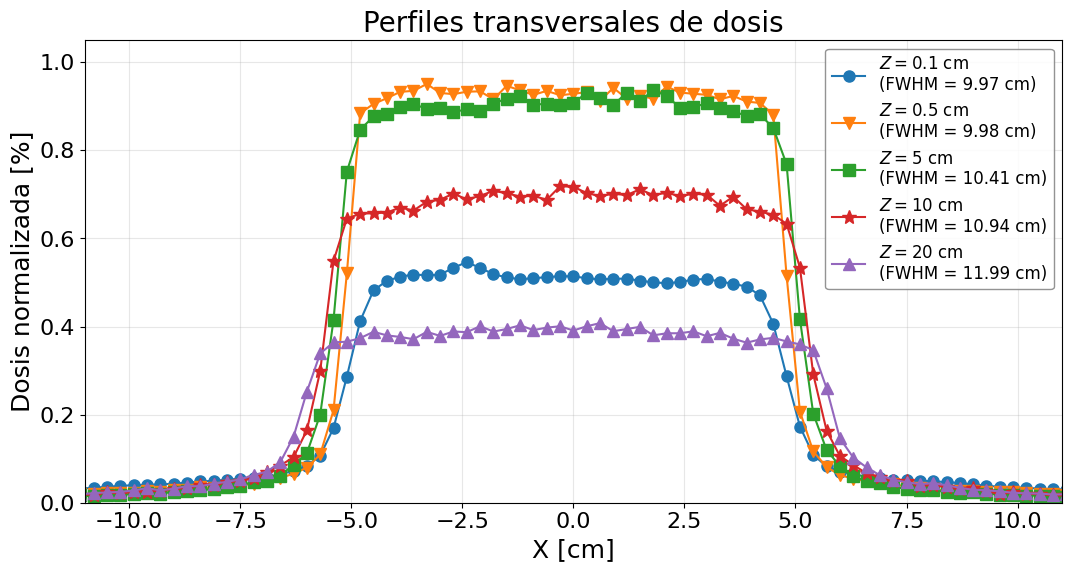

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 20,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
})

def sum_dose(*dfs, dose_col="Dose"):
    """Suma la columna Dose de varios dataframes (mismo largo)."""
    out = pd.DataFrame()
    s = np.zeros(len(dfs[0]), dtype=float)
    for df in dfs:
        s += df[dose_col].to_numpy(dtype=float)
    out["Dose"] = s
    return out

def fwhm_from_profile(x, y, half_max=0.5):
    """
    Calcula FWHM (en unidades de x) de un perfil 1D.
    Usa interpolación lineal en los cruces con half_max.
    Retorna np.nan si no hay dos cruces.
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    if not np.isfinite(y).any():
        return np.nan

    y_max = np.nanmax(y)
    if y_max <= 0:
        return np.nan

    y_n = y / y_max
    level = half_max

    above = y_n >= level
    idx = np.where(np.diff(above.astype(int)) != 0)[0]
    if idx.size < 2:
        return np.nan

    i1 = idx[0]
    i2 = idx[-1]

    def interp_cross(i):
        x0, x1 = x[i], x[i+1]
        y0, y1 = y_n[i], y_n[i+1]
        if y1 == y0:
            return 0.5 * (x0 + x1)
        t = (level - y0) / (y1 - y0)
        return x0 + t * (x1 - x0)

    x_left = interp_cross(i1)
    x_right = interp_cross(i2)

    return float(x_right - x_left)

def smooth_profile(y, sigma_cm, dx_cm=0.3):
    """
    Suavizado gaussiano 1D en unidades físicas.
    sigma_cm: suavizado (cm). Ej: 0.15–0.30 es MUY suave para dx=0.3.
    """
    sigma_bins = sigma_cm / dx_cm
    return gaussian_filter1d(np.asarray(y, dtype=float), sigma=sigma_bins, mode="nearest")

perfil01_suma_medio = sum_dose(perfil01_data_medio_1, perfil01_data_medio_2, perfil01_data_medio_3,
                               perfil01_data_medio_4, perfil01_data_medio_5, perfil01_data_medio_6)

perfil05_suma_medio = sum_dose(perfil05_data_medio_1, perfil05_data_medio_2, perfil05_data_medio_3,
                               perfil05_data_medio_4, perfil05_data_medio_5, perfil05_data_medio_6)

perfil5_suma_medio = sum_dose(perfil5_data_medio_1, perfil5_data_medio_2, perfil5_data_medio_3,
                              perfil5_data_medio_4, perfil5_data_medio_5, perfil5_data_medio_6)

perfil10_suma_medio = sum_dose(perfil10_data_medio_1, perfil10_data_medio_2, perfil10_data_medio_3,
                               perfil10_data_medio_4, perfil10_data_medio_5, perfil10_data_medio_6)

perfil20_suma_medio = sum_dose(perfil20_data_medio_1, perfil20_data_medio_2, perfil20_data_medio_3,
                               perfil20_data_medio_4, perfil20_data_medio_5, perfil20_data_medio_6)

dose_max_ref = float(perfil05_suma_medio["Dose"].max()) +  3e-07

for df in [perfil01_suma_medio, perfil05_suma_medio, perfil5_suma_medio, perfil10_suma_medio, perfil20_suma_medio]:
    df["Dose_normalized"] = df["Dose"] / dose_max_ref

dx = 0.3
X = np.arange(-15, 15, dx)

y01 = perfil01_suma_medio["Dose_normalized"].to_numpy(dtype=float)
y05 = perfil05_suma_medio["Dose_normalized"].to_numpy(dtype=float)
y5  = perfil5_suma_medio["Dose_normalized"].to_numpy(dtype=float)
y10 = perfil10_suma_medio["Dose_normalized"].to_numpy(dtype=float)
y20 = perfil20_suma_medio["Dose_normalized"].to_numpy(dtype=float)

y01_s = smooth_profile(y01, sigma_cm=0.30, dx_cm=dx)
y05_s = smooth_profile(y05, sigma_cm=0.08, dx_cm=dx)
y5_s  = smooth_profile(y5,  sigma_cm=0.08, dx_cm=dx)
y10_s = smooth_profile(y10, sigma_cm=0.08, dx_cm=dx)
y20_s = smooth_profile(y20, sigma_cm=0.08, dx_cm=dx)

fwhm01 = fwhm_from_profile(X, y01_s)
fwhm05 = fwhm_from_profile(X, y05_s)
fwhm5  = fwhm_from_profile(X, y5_s)
fwhm10 = fwhm_from_profile(X, y10_s)
fwhm20 = fwhm_from_profile(X, y20_s)

def fmt_fwhm(v):
    return "N/A" if (v is None or np.isnan(v)) else f"{v:.2f} cm"

plt.figure(figsize=(11, 6))

plt.plot(X, y01_s, marker="o", markersize=8,
         label=rf"$Z=0.1$ cm" "\n" rf"(FWHM = {fmt_fwhm(fwhm01)})")

plt.plot(X, y05_s, marker="v", markersize=8,
         label=rf"$Z=0.5$ cm" "\n" rf"(FWHM = {fmt_fwhm(fwhm05)})")

plt.plot(X, y5_s, marker="s", markersize=8,
         label=rf"$Z=5$ cm" "\n" rf"(FWHM = {fmt_fwhm(fwhm5)})")

plt.plot(X, y10_s, marker="*", markersize=10,
         label=rf"$Z=10$ cm" "\n" rf"(FWHM = {fmt_fwhm(fwhm10)})")

plt.plot(X, y20_s, marker="^", markersize=8,
         label=rf"$Z=20$ cm" "\n" rf"(FWHM = {fmt_fwhm(fwhm20)})")

plt.xlim(-11, 11)
plt.ylim(0, 1.05)
plt.xlabel("X [cm]")
plt.ylabel("Dosis normalizada [%]")
plt.title("Perfiles transversales de dosis")
plt.grid(True, alpha=0.30)
plt.legend(
    loc="upper right",
    fontsize=12,
    frameon=True,
    framealpha=0.85,
    edgecolor="gray",
    ncol=1
)
plt.tight_layout()

plt.savefig("PerfilesTransversales_FWHM.png", dpi=600, bbox_inches="tight", facecolor="white")
plt.show()


# Datos medidos

In [ ]:
import pandas as pd
from pathlib import Path

def parse_mcc_file(path):
    """
    Lee un archivo .mcc (formato IBA CC-Export) y devuelve:
      - global_meta: dict con metadatos globales del archivo
      - scans: lista de dicts con:
          'meta': metadatos del scan
          'data': lista de tuplas (pos, ch1, ch2)
    """
    text = Path(path).read_bytes().decode("latin-1", errors="ignore")
    lines = text.splitlines()

    global_meta = {}
    scans = []

    i = 0
    n = len(lines)

    # 1) Metadatos globales antes del primer BEGIN_SCAN
    while i < n:
        line = lines[i].rstrip("\n")
        stripped = line.strip()

        if stripped.startswith("BEGIN_SCAN"):
            break

        # Líneas tipo KEY=VALUE a nivel global
        if "=" in stripped and not stripped.startswith("BEGIN_"):
            key, val = stripped.split("=", 1)
            global_meta[key.strip()] = val.strip()

        i += 1

    # 2) Scans
    while i < n:
        line = lines[i].strip()

        if line.startswith("BEGIN_SCAN"):
            scan = {"meta": {}, "data": []}
            i += 1

            while i < n:
                s = lines[i].strip()

                if s.startswith("END_SCAN"):
                    break

                # Bloque de datos
                if s.startswith("BEGIN_DATA"):
                    i += 1
                    while i < n:
                        d = lines[i].strip()
                        if d.startswith("END_DATA"):
                            break
                        if d:
                            parts = d.split()
                            if len(parts) >= 3:
                                try:
                                    pos = float(parts[0])
                                    ch1 = float(parts[1])
                                    ch2 = float(parts[2])
                                    scan["data"].append((pos, ch1, ch2))
                                except ValueError:
                                    pass
                        i += 1
                else:
                    # Metadatos del scan (KEY=VALUE)
                    if "=" in s:
                        key, val = s.split("=", 1)
                        scan["meta"][key.strip()] = val.strip()
                    i += 1

            scans.append(scan)

        i += 1

    return global_meta, scans

def scans_to_dataframe(scans):
    """
    Convierte la lista de scans a un único DataFrame de puntos.
    Cada fila = un punto (posición + señales) con sus metadatos principales.
    """
    rows = []
    for idx, scan in enumerate(scans, start=1):
        meta = scan["meta"]

        curve_type = meta.get("SCAN_CURVETYPE", "")
        off_inplane = float(meta.get("SCAN_OFFAXIS_INPLANE", "0") or 0)
        off_crossplane = float(meta.get("SCAN_OFFAXIS_CROSSPLANE", "0") or 0)
        ssd = float(meta.get("SSD", "0") or 0)
        energy = float(meta.get("ENERGY", "0") or 0)
        field_inplane = float(meta.get("FIELD_INPLANE", "0") or 0)
        field_crossplane = float(meta.get("FIELD_CROSSPLANE", "0") or 0)
        medium = meta.get("MEAS_MEDIUM", "")

        for pos, sig, ref in scan["data"]:
            rows.append({
                "scan_index": idx,
                "curve_type_raw": curve_type,
                "position_mm": pos,           # profundidad o eje lateral
                "signal": sig,                # canal de medición
                "ref_signal": ref,            # canal de referencia
                "offaxis_inplane_mm": off_inplane,
                "offaxis_crossplane_mm": off_crossplane,
                "SSD_mm": ssd,
                "Energy_MV": energy,
                "Field_inplane_mm": field_inplane,
                "Field_crossplane_mm": field_crossplane,
                "Medium": medium,
            })

    df = pd.DataFrame(rows)
    return df

def classify_curve_type(curve_type_raw):
    """
    Devuelve una categoría normalizada:
      - 'PDD'
      - 'PROFILE_INPLANE'
      - 'PROFILE_CROSSPLANE'
      - 'PROFILE_OTHER'
      - 'OTHER'
    """
    if not isinstance(curve_type_raw, str):
        return "OTHER"

    s = curve_type_raw.upper().strip()

    if "PDD" in s or "DEPTH" in s:
        return "PDD"

    if "INPLANE" in s or "IN-PLANE" in s:
        return "PROFILE_INPLANE"

    if ("CROSSPLANE" in s or "CROSS-PLANE" in s or "CROSS" in s):
        return "PROFILE_CROSSPLANE"

    if "PROFILE" in s:
        return "PROFILE_OTHER"

    return "OTHER"

def scans_meta_to_dataframe(scans):
    """
    Convierte los metadatos de cada scan en un DataFrame.
    Una fila por scan.
    """
    rows = []
    for idx, scan in enumerate(scans, start=1):
        meta = scan["meta"].copy()
        meta["scan_index"] = idx
        rows.append(meta)
    df_meta = pd.DataFrame(rows)
    return df_meta

def load_mcc_as_dataframes(mcc_path):
    """
    Carga un .mcc y devuelve:
      - global_meta: dict con cabecera global
      - df_scan_meta: DataFrame con metadatos por scan
      - dfs: dict con DataFrames por tipo de curva:
          'all', 'pdd', 'profile_inplane', 'profile_crossplane', 'profile_other', 'other'
    """
    global_meta, scans = parse_mcc_file(mcc_path)
    df_all = scans_to_dataframe(scans)
    df_all["curve_type"] = df_all["curve_type_raw"].apply(classify_curve_type)

    # DataFrames por tipo
    df_pdd = df_all[df_all["curve_type"] == "PDD"].copy()
    df_profile_inplane = df_all[df_all["curve_type"] == "PROFILE_INPLANE"].copy()
    df_profile_crossplane = df_all[df_all["curve_type"] == "PROFILE_CROSSPLANE"].copy()
    df_profile_other = df_all[df_all["curve_type"] == "PROFILE_OTHER"].copy()
    df_other = df_all[df_all["curve_type"] == "OTHER"].copy()

    df_scan_meta = scans_meta_to_dataframe(scans)

    dfs = {
        "all": df_all,
        "pdd": df_pdd,
        "profile_inplane": df_profile_inplane,
        "profile_crossplane": df_profile_crossplane,
        "profile_other": df_profile_other,
        "other": df_other,
    }

    return global_meta, df_scan_meta, dfs

# Ruta al archivo .mcc
mcc_file = "/content/X06 OPEN 10X10 PDD WAT 230131 17'03'50.mcc"

global_meta, df_scan_meta, dfs = load_mcc_as_dataframes(mcc_file)

print("Metadatos globales:")
print(global_meta)

print("\nMetadatos de scans:")
print(df_scan_meta)

print("\nResumen por tipo de curva:")
print(dfs["all"].groupby(["scan_index", "curve_type_raw", "curve_type"])[["position_mm"]].count())



Metadatos globales:
{}

Metadatos de scans:
           FORMAT    FILE_CREATION_DATE         LAST_MODIFIED  \
0  CC-Export V1.9  31-Jan-2023 17:03:52  31-Jan-2023 17:03:52   

          TASK_NAME         PROGRAM             MEAS_DATE LINAC MODALITY  \
0  tba PDD Profiles  WaterTankScans  31-Jan-2023 17:01:26    IX        X   

   ISOCENTER INPLANE_AXIS_DIR  ... MEAS_TIME MEAS_UNIT PRESSURE TEMPERATURE  \
0  -99999.00       TARGET_GUN  ...     0.200      A.U.  1013.20       20.00   

  NORM_TEMPERATURE CORRECTION_FACTOR EXPECTED_MAX_DOSE_RATE EPOM_DEPTH_SHIFT  \
0            20.00            1.0000                   4.00              0.0   

  EPOM_MODE scan_index  
0    TRUFIX          1  

[1 rows x 75 columns]

Resumen por tipo de curva:
                                      position_mm
scan_index curve_type_raw curve_type             
1          PDD            PDD                 301


14
35


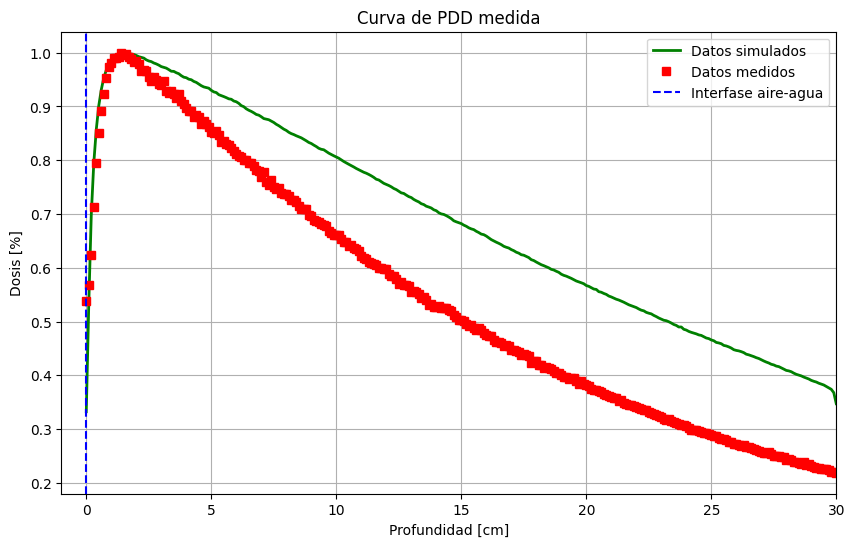

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_pdd = dfs["pdd"]
df_pdd.head()
df_pdd["dose_corr"] = df_pdd["signal"] / df_pdd["ref_signal"]
df_pdd["dose_norm"] = df_pdd["dose_corr"] / df_pdd["dose_corr"].max()
df_pdd_sim = pdd_suma_medio['Dose_normalized']

Z = np.arange(0, 30.1, 0.1)
plt.figure(figsize=(10, 6))
plt.plot(Z, df_pdd_sim[19:], linewidth = 2.0, color = "g", label = "Datos simulados")
plt.plot(Z, df_pdd["dose_norm"], "sr", label = "Datos medidos")
plt.xlabel('Profundidad [cm]')
plt.ylabel('Dosis [%]')
plt.xlim(-1, 30)
plt.axvline(x = 0, color = 'b', linestyle = '--', label = 'Interfase aire-agua')
plt.title('Curva de PDD medida')
plt.grid(True)
plt.legend()
plt.show()

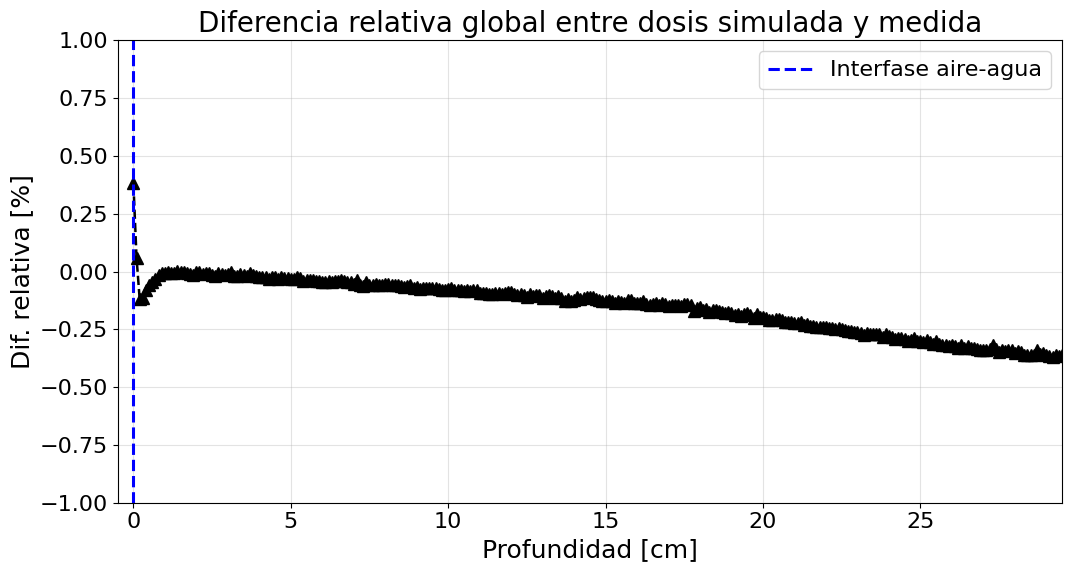

In [ ]:
import numpy as np

diff_relat_global = (dose_meas - dose_sim_corr)/dose_meas
plt.figure(figsize=(11, 6))
plt.plot(Z_sim, diff_relat_global, "--^k", linewidth=1.8, markersize = 8)
plt.axvline(x = 0, color = 'b', linestyle = '--', linewidth=2.2, label = 'Interfase aire-agua')
plt.xlabel("Profundidad [cm]")
plt.ylabel("Dif. relativa [%]")
plt.xlim(-0.5, 29.5)
plt.ylim(-1, 1)
plt.grid(True, alpha=0.35)
plt.title("Diferencia relativa global entre dosis simulada y medida")
plt.tight_layout()
plt.savefig("PDDGlobal_DiferenciaPorcentual.png", dpi=600)
plt.legend()
plt.show()

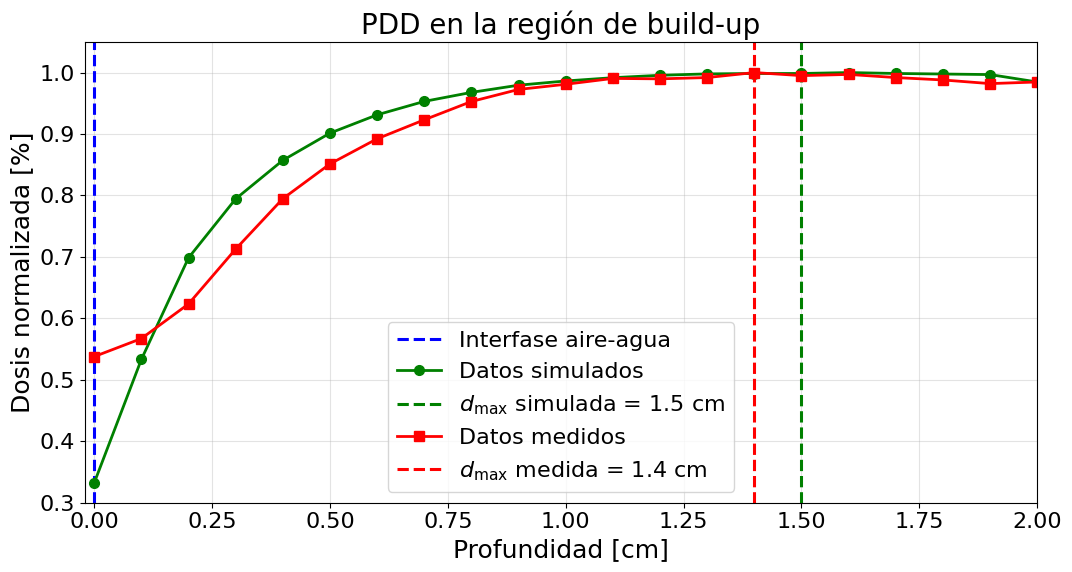

In [ ]:
plt.figure(figsize=(11, 6))
plt.axvline(x = 0, color = 'b', linestyle = '--', linewidth=2.2, label = 'Interfase aire-agua')
plt.plot(Z_sim, dose_sim_corr, "-og", linewidth=2, markersize=7, label="Datos simulados")
plt.axvline(x = 0.1*(pdd_suma_medio["Dose_normalized"].idxmax() - 20) , color = 'green', linestyle = '--', linewidth=2.2, label = r'$d_{\max}$ simulada = 1.5 cm')
plt.plot(Z_meas, dose_meas, "-sr", linewidth=2, markersize=7, label="Datos medidos")
plt.axvline(x = 0.1*df_pdd["dose_norm"].idxmax() , color = 'red', linestyle = '--', linewidth=2.2, label = r'$d_{\max}$ medida = 1.4 cm')
plt.xlabel("Profundidad [cm]")
plt.ylabel("Dosis normalizada [%]")
plt.xlim(-0.02, 2)
plt.ylim(0.3, 1.05)
plt.grid(True, alpha=0.35)
plt.title("PDD en la región de build-up")
plt.legend()
plt.savefig("PDDBuildUp.png", dpi=600)
plt.tight_layout()
plt.show()

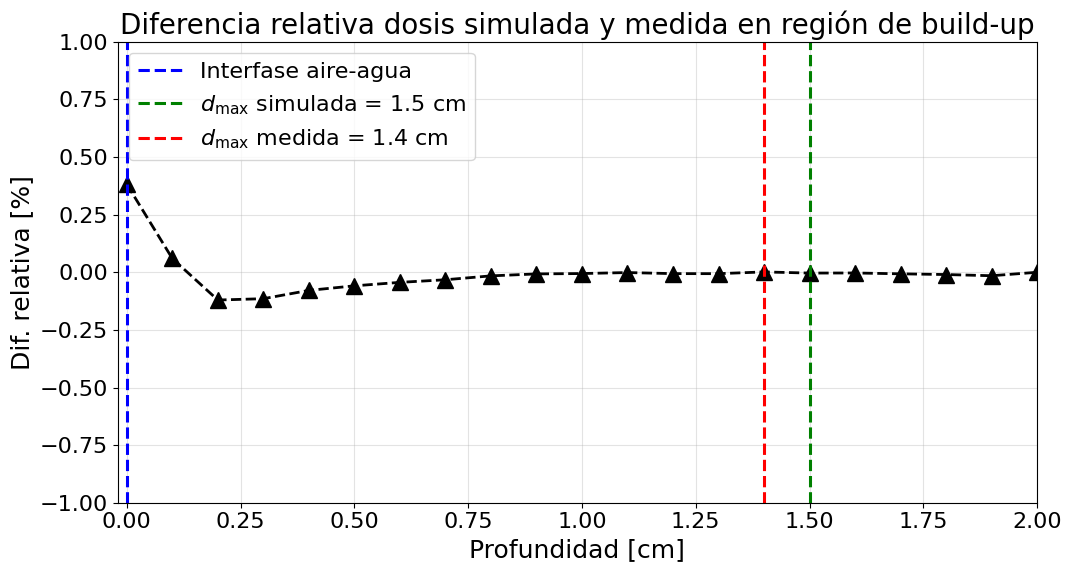

In [ ]:
import numpy as np

diff_relat_global = (dose_meas - dose_sim_corr)/dose_meas
plt.figure(figsize=(11, 6))
plt.plot(Z_sim, diff_relat_global, "--^k", linewidth=2, markersize = 11)
plt.axvline(x = 0, color = 'b', linestyle = '--', linewidth=2.2, label = 'Interfase aire-agua')
plt.axvline(x = 0.1*(pdd_suma_medio["Dose_normalized"].idxmax() - 20) , color = 'green', linestyle = '--', linewidth=2.2, label = r'$d_{\max}$ simulada = 1.5 cm')
plt.axvline(x = 0.1*df_pdd["dose_norm"].idxmax() , color = 'red', linestyle = '--', linewidth=2.2, label = r'$d_{\max}$ medida = 1.4 cm')
plt.xlabel("Profundidad [cm]")
plt.ylabel("Dif. relativa [%]")
plt.xlim(-0.02, 2)
plt.ylim(-1, 1)
plt.grid(True, alpha=0.35)
plt.title("Diferencia relativa dosis simulada y medida en región de build-up")
plt.tight_layout()
plt.savefig("PDDBuildUp_DiferenciaPorcentual.png", dpi=600)
plt.legend()
plt.show()